Group Members: Jack Rosener, Jackson Joffe, and Josh Weiner

# **Using Machine Learning to Predict the Outcome of NBA Games**

In this project, we use the skills and techniques learned throughout the course to predict the winner of NBA games. We start by scraping large amounts of data from the past 12 seasons of the NBA. This data consists of both individual player and team statistics. We then apply various machine learning methods and approaches to attempt to create a accurate a model as possible to solve the classification problem at hand.   

# Section 0: Initialization and Importing Libraries

In [ ]:
#necessary set up for the Selenium library
!apt update
!apt install chromium-chromedriver
!pip install selenium

#set options for Selenium, ..
from selenium import webdriver
from selenium.webdriver.support.ui import Select
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

#more imports
import pandas as pd
import scipy
import numpy as np
import time
import json
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [40.7 kB]
Get:12 http://ppa.launchpad.net/graph

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Section 1: Web Scraping 

Before we can start using machine learning and making predictions, we first need to get our data. Our data source will be [SynergySports.com](https://www.synergysportstech.com/synergy/), which contains rich player and team stats of previous NBA season. In total, we will scrape all the player and team statistics that Synergy Sports has on their website since the 2008-2009 NBA season. These stats will consist of values such as points, rebounds, assists, fouls, and more. 


The main library we will use to scrape this data is Selenium. Synergy Sports requires a login to access its site and much of the data is hidden behind drop down selections, thus we will need to programatically interact with the website to extract the data. The Selenium library gives us this ability to interact with webpages as well as extract the underlying html, thus it is a good choice.  

**Note: this code takes an extremely long time to run, so please do not run any cells** 

## 1.1: Scraping Urls    

The data for each NBA game that Synergy Sports has on their website is contained on a unique page. Thus, to start the scraping process we will first gather all the urls to these web pages. We will save these urls in a dict called *url_data*. The keys of this dictionary will be a given season, and the values will be the urls in that season. Once we have all the urls in *url_data*, we will write the urls to a json document so that later we can quickly iterate through each url and get the data from that page. 

### Logging into the Synergy Sports Site

In [ ]:
#initialize webdriver
driver = webdriver.Chrome(options=options)

#get login page of Synergy Sports
driver.get('https://www.synergysportstech.com/synergy/')

#login to website
driver.find_element_by_id('txtUserName').send_keys('USERNAME')
driver.find_element_by_id('txtPassword').send_keys('PASSWORD')
driver.find_element_by_id('btnLogin').click() 

### Getting the urls
In this cell we do all the work to extract the hrefs of all the urls to the games on Synergy's site

In [ ]:
#the code in this cell gets the urls to all the boxscores of every game on the Synegery Sports site

driver.get('https://www.synergysportstech.com/Synergy/Sport/Basketball/web/teamsst/Video/SelectGame2.aspx')

url_data = {}

league = 'NBA'

#select the league from the drop down menu (NBA or NCAA)
Select(driver.find_element_by_id('ctl00_MainContent_lstLeague')).select_by_visible_text(league)
time.sleep(3)

#get the element on the webpage where you can select a season 
season_selector_drop_down = Select(driver.find_element_by_id('ctl00_MainContent_lstSeason'))

#list of all the possible seasons that can be selected
seasons = [x.text for x in season_selector_drop_down.options] 

for i, season in enumerate(seasons) :

  #select the given season 
  Select(driver.find_element_by_id('ctl00_MainContent_lstSeason')).select_by_index(i)
  time.sleep(3)

  #we will map each team to a list of urls which are the links to the boxscores of every game that team played
  team_to_url_dict = {}

  #get the list of teams
  team_selector_drop_down = Select(driver.find_element_by_id('ctl00_MainContent_lstTeamA'))
  teams = [x.text for x in team_selector_drop_down.options][1:] 

  for j, team in enumerate(teams) :

    try :
      #select a specific team
      Select(driver.find_element_by_id('ctl00_MainContent_lstTeamA')).select_by_index(j + 1)
      time.sleep(3)
    except StaleElementReferenceException: 
      time.sleep(5)
      Select(driver.find_element_by_id('ctl00_MainContent_lstTeamA')).select_by_index(j + 1)
      time.sleep(3)


    elems = driver.find_elements_by_xpath("//table//td[2]/a[@href]")[1:]

    #if the site doesn't have more than 10 games on a team in a season, it isn't worth scraping their data
    if len(elems) > 10  :
      team_to_url_dict[team] = [x.get_attribute('href') for x in elems]
    print('Team: ', j, ' done.')
    
  url_data[season] = team_to_url_dict
  print('Season: ', season, ' done.')
  print(' ')

driver.quit()

### Take a look at urls we just scraped

In [1]:
len(url_data)

NameError: ignored

### Write the data to a JSON document

In [ ]:
#in this cell we write the data we just found above to a json file so the data will persist
url_data_json = json.dumps(url_data, indent=4)

with open("'/content/drive/MyDrive/NBA_Data/NBA_boxscores_urls.json'", "w") as outfile: 
    #outfile.write(url_data_json) 

## 1.2: Scraping the Data 
Now that we have the urls to all the games we need to scrape, we will visit those urls and scrape the box scores of each game. Since scraping takes quite a long time, we will save the data we collect incrementally. For each season, we will save one csv file for the team stats of that year and one for the player stats.

### Read in the urls to the links we just scraped

In [ ]:
#load the NBA boxscore urls into a dictionary
with open('/content/drive/MyDrive/NBA_Data/NBA_boxscores_urls.json') as json_file: 
    nba_url_data = json.load(json_file)

### Define a whole bunch of helper functions for scraping
Below we have a bunch of long and ugly functions that will ultimately be used to scrape the data 

In [ ]:
#given the url of a game on the synergy sports site, this method scrapes all the player stats from that game and returns
#the data in the form of a dataframe

def scrape_player_stats_of_game(game_url) :
  driver.get(game_url)

  WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.XPATH, '//*[@class="Tier3Header"]')))

  game_info_element = driver.find_elements_by_xpath('//*[@class = "ReportHeader1"]//td')

  game_id = driver.current_url.split('=')[1]
  game_date = game_info_element[10].text
  
  away_team = game_info_element[1].text
  home_team = game_info_element[6].text

  html = driver.page_source
  tables = pd.read_html(html, header = 0)

  home_team_box = pd.concat([tables[10].iloc[:-1], tables[11].iloc[:-1].drop(columns = home_team)], axis = 1).rename(columns = {home_team : 'Player_Name'}) 
  home_team_box['Player_team'] = home_team
  home_team_box['Opposing_team'] = away_team

  away_team_box = pd.concat([tables[12].iloc[:-1], tables[13].iloc[:-1].drop(columns = away_team)], axis = 1).rename(columns = {away_team : 'Player_Name'})
  away_team_box['Player_team'] = away_team
  away_team_box['Opposing_team'] = home_team

  player_stats_df = pd.concat([home_team_box, away_team_box])
  player_stats_df['Date'] = game_date
  player_stats_df['Game_ID'] = game_id
  
  return player_stats_df

In [ ]:
#this method extracts all the team stats from both teams of a given game

def extract_team_box_score(tables) :
  general_team_stats = tables[10]
  general_team_stats = general_team_stats.rename(columns=general_team_stats.iloc[0]).drop(0)
  general_team_stats.set_index('Element Title', inplace = True)

  team_shooting_stats = tables[11]
  team_shooting_stats = team_shooting_stats.rename(columns=team_shooting_stats.iloc[0]).drop(0)
  team_shooting_stats.set_index('Element Title', inplace = True)
  team_shooting_stats.drop('Element Title', inplace = True)

  return pd.concat([general_team_stats, team_shooting_stats])

In [ ]:
#This method takes in the combined box score from both teams, and returns only the home team or the away team stats, 
#depending on the input to the function. 

def get_home_or_away_team_stats(team_box_score, tables, home_team = False) :
  game_info_element = driver.find_elements_by_xpath('//*[@class = "ReportHeader1"]//td')
  
  if home_team == True :
    team = 'Home'
    cols = [0,3,6,9,12]
    overall_record = game_info_element[9].text[1:-1]
    home_or_away_record = game_info_element[8].text[1:-1].split('Home')[0].strip()
  else :
    team = "Away"
    cols = [1,4,7,10,13]
    overall_record = game_info_element[4].text[1:-1]
    home_or_away_record = game_info_element[3].text[1:-1].split('Away')[0].strip()

  team_stats = team_box_score.iloc[6:25, cols]
  team_stats.columns = ['', '1', '2', '3','4']

  team_stats = team_stats.stack()

  team_stats.index = team_stats.index.map((team[0] + '_{0[0]}_{0[1]}').format)
  team_stats = team_stats.to_frame().T

  if home_team == True :
    team_points_stats = pd.DataFrame(tables[8].iloc[1]).T
  else :
      team_points_stats = pd.DataFrame(tables[8].iloc[0]).T

  team_points_stats.reset_index(inplace=True, drop = True)
  team_points_stats.columns = [team[0]+'_Team', team[0] + '_Points', team[0] + '_Points_1', team[0] + '_Points_2', team[0] + '_Points_3', team[0] + '_Points_4']

  overall_team_stats = pd.concat([team_points_stats, team_stats], axis = 1)
  overall_team_stats[team + '_Team_Overall_Record'] = overall_record
  overall_team_stats[team + '_Team_' + team +'_Record'] = home_or_away_record 

  return overall_team_stats

In [ ]:
#This method will scrape the team stats from both the home and away team of a game, then combine all the data into a single Pandas series

def scrape_team_stats_of_game() :
  game_info_element = driver.find_elements_by_xpath('//*[@class = "ReportHeader1"]//td')

  game_date = game_info_element[10].text
  game_id = driver.current_url.split('=')[1]

  driver.find_element_by_id('ctl00_MainContent_btnTeamStats').click()
  try:
    WebDriverWait(driver, 20).until(EC.visibility_of_element_located((By.XPATH, '//*[@class="TierCaption2"]')))
  except:
    return None
  
  tables = pd.read_html(driver.page_source, header = 0)
  if len(tables[8].columns) > 6 :
    return None 

  team_box_score = extract_team_box_score(tables)

  home_team_stats = get_home_or_away_team_stats(team_box_score, tables, home_team = True)
  away_team_stats = get_home_or_away_team_stats(team_box_score, tables, home_team = False)

  team_stats_df = pd.concat([home_team_stats, away_team_stats], axis = 1) 

  team_stats_df['Date'] = game_date
  team_stats_df['Game_ID'] = game_id
  
  return team_stats_df

In [ ]:
def get_urls_of_games_in_season(season) :
  urls = []
  for team in nba_url_data[season] :
    for url in nba_url_data[season][team] :
      urls.append(url)
  
  return list(set(urls))

In [ ]:
#This method puts it all together. Given a season it will extract all the player and team stats from every game in that season. 
#It returns this data as a tuple of dataframes.

def get_player_and_team_stats_of_season(season) :
  player_stats_df_total = pd.DataFrame()
  team_stats_df_total = pd.DataFrame()
  game_urls = get_urls_of_games_in_season(season)

  for i, game in enumerate(game_urls) :
    try : 
      player_stats_of_curr_game = scrape_player_stats_of_game(game)
    except Exception :
      continue


    player_stats_df_total = player_stats_df_total.append(player_stats_of_curr_game)
  
    team_stats_of_curr_game = scrape_team_stats_of_game()
  
    if team_stats_of_curr_game is not None :
      team_stats_df_total = team_stats_df_total.append(team_stats_of_curr_game)

    print('Game ', i, ' done.')

  player_stats_df_total.reset_index(inplace=True, drop=True)
  player_stats_df_total['Season'] = season

  team_stats_df_total.reset_index(inplace=True, drop=True)
  team_stats_df_total.columns = team_stats_df_total.columns.str.replace(' ', '_')
  team_stats_df_total['Season'] = season
  
  return player_stats_df_total, team_stats_df_total

In [ ]:
#This method writes the data from a single season to two separate csv files 

def write_data_of_season(player_stats_data, team_stats_data, season) :
  #player_stats_data.to_csv( ('/content/drive/My Drive/NBA_Data/Player_Stats_' + season + '.csv') )
  #team_stats_data.to_csv( ('/content/drive/My Drive/NBA_Data/Team_Stats_' + season + '.csv') )

### Put it all together and scrape the team and player stats 
Below we iterate though each season from the last 12 years, scrape the neccesary data then save the data to csv files

In [ ]:
seasons = list(NBA_url_data.keys())

for season in seasons :

  player_stats_df_total, team_stats_df_total = get_player_and_team_stats_of_season(season)

  #write_data_of_season(player_stats_df_total, team_stats_df_total, season)

  print('Season ', season, ' done.')

driver.quit()

# Section 2: Data Cleaning
We now have player stats and team stats for each NBA season saved as seperate csv files for each season. The next step is to read in all this data and combine it into two large dataframes. One will contain all the player stats for the past 10 seasons and the other will contain all the team stats. Once we have combined it, we will do some cleaning on the data. 

The ultimate output of this section will be **cleaned_player_stats_df** and **cleaned_team_stats_df**. These will both be saved as csv files for later. 

## 2.1: Combining the data
The first step is to combine all the data. We will comine all the player stats we scraped into a dataframe called **player_stats_combined_df** and the team stats to a dataframe called **team_stats_combined_df**. We then display the dataframes to see what we have.

In [ ]:
#read in and combine the data from every season into two dataframes, one containing team stats and the other contianing player stats
start_year = 2008
end_year = 2009

team_stats_combined_df = pd.DataFrame()
player_stats_combined_df = pd.DataFrame()

for i in range(12) :
  team_stats_file_path = '/content/drive/MyDrive/NBA_Data/Team_Stats_' + str(start_year) + " - " + str(end_year) + '.csv'
  player_stats_file_path = '/content/drive/MyDrive/NBA_Data/Player_Stats_' + str(start_year) + " - " + str(end_year) + '.csv'

  team_stats_combined_df = team_stats_combined_df.append(pd.read_csv(team_stats_file_path, index_col = 0))
  player_stats_combined_df = player_stats_combined_df.append(pd.read_csv(player_stats_file_path, index_col = 0))

  start_year = start_year + 1
  end_year = end_year + 1

Let's view the data we've scraped

In [ ]:
player_stats_combined_df.head(5)

,Player_Name,Min,SST,SSTexPts,Pts,PPP,Ast,T/O,Ast/TO,Stl,StlPos,Blk,BlkFGA,TtlReb,OffReb,DefReb,FGA,FGM,FGm,FG%,aFG%,2FGA,2FGM,2FGm,2FG%,3FGA,3FGM,3FGm,3FG%,FTA,FTM,FTm,FT%,+1,ChgTkn,ChgCom,PFTkn,PFCom,Player_team,Opposing_team,Date,Game_ID,Season
0,#0 Leon Powe,41:00,2.31,0.59,30,1.50,3,0,0.0,1,0,0,0,11,5,6,14,10,4,71.4%,71.4%,14,10,4,71.4%,0,0,0,-,14,10,4,71.4%,2,0,0,9,0,Boston Celtics,Memphis Grizzlies,3/13/2009,19171,2008 - 2009
1,#4 JR Giddens,-,-,-,0,-,0,0,0.0,0,0,0,0,0,0,0,0,0,0,-,-,0,0,0,-,0,0,0,-,0,0,0,-,0,0,0,0,0,Boston Celtics,Memphis Grizzlies,3/13/2009,19171,2008 - 2009
2,#7 Mikki Moore,22:00,0.97,0.55,6,1.20,2,2,1.0,0,0,1,0,8,2,6,3,3,0,100%,100%,3,3,0,100%,0,0,0,-,0,0,0,-,0,0,1,0,0,Boston Celtics,Memphis Grizzlies,3/13/2009,19171,2008 - 2009
3,#8 Stephon Marbury,17:00,1.21,0.65,9,1.00,5,1,5.0,0,0,1,0,1,0,1,9,4,5,44.4%,50%,7,3,4,42.9%,2,1,1,50%,0,0,0,-,0,0,0,0,0,Boston Celtics,Memphis Grizzlies,3/13/2009,19171,2008 - 2009
4,#9 Rajon Rondo,29:00,0.75,0.69,4,0.40,8,4,2.0,1,1,0,0,8,2,6,7,2,5,28.6%,28.6%,7,2,5,28.6%,0,0,0,-,0,0,0,-,0,0,0,0,0,Boston Celtics,Memphis Grizzlies,3/13/2009,19171,2008 - 2009


In [ ]:
team_stats_combined_df.head(5)

,H_Team,H_Points,H_Points_1,H_Points_2,H_Points_3,H_Points_4,H_Total_Rebounds_,H_Total_Rebounds_1,H_Total_Rebounds_2,H_Total_Rebounds_3,H_Total_Rebounds_4,H_Offensive_Rebounds_,H_Offensive_Rebounds_1,H_Offensive_Rebounds_2,H_Offensive_Rebounds_3,H_Offensive_Rebounds_4,H_Defensive_Rebounds_,H_Defensive_Rebounds_1,H_Defensive_Rebounds_2,H_Defensive_Rebounds_3,H_Defensive_Rebounds_4,H_Assists_,H_Assists_1,H_Assists_2,H_Assists_3,H_Assists_4,H_Turnovers_,H_Turnovers_1,H_Turnovers_2,H_Turnovers_3,H_Turnovers_4,H_Steals_,H_Steals_1,H_Steals_2,H_Steals_3,H_Steals_4,H_Blocks_,H_Blocks_1,H_Blocks_2,H_Blocks_3,...,A_FG_Made_,A_FG_Made_1,A_FG_Made_2,A_FG_Made_3,A_FG_Made_4,A_FG_Missed_,A_FG_Missed_1,A_FG_Missed_2,A_FG_Missed_3,A_FG_Missed_4,A_2FG_Attempts_,A_2FG_Attempts_1,A_2FG_Attempts_2,A_2FG_Attempts_3,A_2FG_Attempts_4,A_2FG_Made_,A_2FG_Made_1,A_2FG_Made_2,A_2FG_Made_3,A_2FG_Made_4,A_2FG_Missed_,A_2FG_Missed_1,A_2FG_Missed_2,A_2FG_Missed_3,A_2FG_Missed_4,A_3FG_Attempts_,A_3FG_Attempts_1,A_3FG_Attempts_2,A_3FG_Attempts_3,A_3FG_Attempts_4,A_3FG_Made_,A_3FG_Made_1,A_3FG_Made_2,A_3FG_Made_3,A_3FG_Made_4,Away_Team_Overall_Record,Away_Team_Away_Record,Date,Game_ID,Season
0,Boston Celtics,102,27,20,29,26,41,11,11,12,9,12,3,1,7,2,29,8,10,5,7,26,4,8,6,7,13,4,3,3,2,8,2,3,1,2,4,0,1,4,...,32,10,6,10,6,42,6,16,10,10,60,15,20,15,10,26,9,5,7,5,34,6,15,8,5,14,1,2,5,6,6,1,1,3,1,16 - 47,4 - 26,3/13/2009,19171,2008 - 2009
1,Los Angeles Lakers,107,37,29,21,20,49,11,11,12,13,14,4,1,2,6,35,7,10,10,7,22,8,6,3,6,16,3,4,5,4,8,3,2,1,2,4,1,3,4,...,33,10,8,9,6,51,11,14,15,11,49,13,15,12,9,20,7,6,3,4,29,6,9,9,5,35,8,7,12,8,13,3,2,6,2,40 - 26,16 - 18,3/15/2009,19188,2008 - 2009
2,Charlotte Hornets,74,14,21,13,26,34,12,6,9,7,11,5,3,2,1,23,7,3,7,6,17,2,5,5,4,19,7,4,5,4,10,1,4,1,3,10,1,1,0,...,32,10,8,6,8,36,12,9,9,6,51,17,14,8,12,23,7,7,2,7,28,10,7,6,5,17,5,3,7,2,9,3,1,4,1,16 - 3,5 - 3,12/6/2008,11183,2008 - 2009
3,Denver Nuggets,122,27,26,36,33,40,9,8,9,12,10,2,3,2,2,30,7,5,7,10,26,7,1,8,11,12,4,1,1,3,11,5,3,2,1,8,1,5,2,...,41,12,12,9,8,45,8,10,13,14,74,16,21,17,20,36,9,12,7,8,38,7,9,10,12,12,4,1,5,2,5,3,0,2,0,21 - 56,7 - 30,4/8/2009,19655,2008 - 2009
4,Houston Rockets,93,19,26,23,25,39,15,6,10,7,5,3,0,1,1,34,12,6,9,6,25,4,6,7,7,12,4,5,2,1,4,1,0,2,1,8,1,3,0,...,26,3,11,5,7,54,14,17,12,11,65,16,20,16,13,20,3,7,5,5,45,13,13,11,8,15,1,8,1,5,6,0,4,0,2,44 - 11,18 - 10,2/26/2009,18837,2008 - 2009


## 2.2: Cleaning *player_stats_combined_df*
Here we clean the **player_stats_combined_df** and save it ultimately to **cleaned_player_stats_df**. We update column names to make them more readable, drop unnecessary columns and invalid entries, and more. 

In [ ]:
#reorder the columns 

player_stats_combined_df.rename(columns = {'Player_team' : 'Player_Team', 'Opposing_team': 'Opposing_Team'}, inplace = True)
l = ['Player_Name', 'Player_Team', 'Opposing_Team', 'Date', 'Game_ID', 'Season']
other = [x for x in player_stats_combined_df.columns if x not in l]
player_stats_combined_df = player_stats_combined_df[l + other]

In [ ]:
#clean the players' names columns

player_stats_combined_df['Player_Name'] = player_stats_combined_df['Player_Name'].apply(lambda x : x[3:].strip()) 

def name_contains_abbreviation(name) :
  for x in name.split(' '): 
    if len(x) <= 2 :
      return True
  return False 

player_stats_combined_df['Player_Name'] = player_stats_combined_df['Player_Name'].apply(lambda x : x.title() if not name_contains_abbreviation(x) else x)
player_stats_combined_df['Player_Name'] = player_stats_combined_df['Player_Name'].apply(lambda x : x[2:] if x[0:2] is '0 ' else x)

In [ ]:
#remove invalid entries

player_stats_combined_df = player_stats_combined_df[(3 * player_stats_combined_df['3FGM'] + 2 * player_stats_combined_df['2FGM'] + \
                                                              player_stats_combined_df['FTM']) == player_stats_combined_df['Pts']]

player_stats_combined_df = player_stats_combined_df[player_stats_combined_df['Min'] != '-']

In [ ]:
#drop uneccessarry columns

player_stats_combined_df.drop(columns = ['FG%', 'aFG%', '3FG%', '2FG%', 'FT%', 'SSTexPts', 'ChgTkn', 'ChgCom', '+1'], inplace = True)

In [ ]:
#convert date column to date time object
player_stats_combined_df['Date'] = pd.to_datetime(player_stats_combined_df['Date'])

In [ ]:
#remove underscores from column names 

player_stats_combined_df.columns = [x.replace('_', '') for x in player_stats_combined_df.columns]

In [ ]:
#sort dataframe by date and reset index
player_stats_combined_df.sort_values(by = 'Date', ascending = False, inplace = True)
player_stats_combined_df.reset_index(inplace = True, drop = True)

Lets view or new cleaned player stats

In [ ]:
#save new data to cleaned_data_frame

cleaned_player_stats_df = player_stats_combined_df

cleaned_player_stats_df

,PlayerName,PlayerTeam,OpposingTeam,Date,GameID,Season,Min,SST,Pts,PPP,Ast,T/O,Ast/TO,Stl,StlPos,Blk,BlkFGA,TtlReb,OffReb,DefReb,FGA,FGM,FGm,2FGA,2FGM,2FGm,3FGA,3FGM,3FGm,FTA,FTM,FTm,PFTkn,PFCom
0,PJ Tucker,Houston Rockets,Philadelphia 76ers,2020-08-14,732811,2019 - 2020,29:03,0.53,7,1.17,2,0,0.0,0,0,1,1,1,0,1,6,3,3,2,2,0,4,1,3,0,0,0,1,2
1,Hamidou Diallo,Oklahoma City Thunder,Los Angeles Clippers,2020-08-14,732813,2019 - 2020,39:47,1.36,27,1.04,1,2,0.5,0,2,1,0,11,4,7,22,10,12,14,6,8,8,4,4,5,3,2,5,5
2,Danilo Galinari,Oklahoma City Thunder,Los Angeles Clippers,2020-08-14,732813,2019 - 2020,8:52,1.39,3,0.75,0,0,0.0,0,0,0,0,1,0,1,3,0,3,2,0,2,1,0,1,3,3,0,1,2
3,Nerlens Noel,Oklahoma City Thunder,Los Angeles Clippers,2020-08-14,732813,2019 - 2020,15:22,0.59,5,1.00,0,2,0.0,0,2,1,0,1,0,1,2,2,0,2,2,0,0,0,0,2,1,1,1,3
4,Steven Adams,Oklahoma City Thunder,Los Angeles Clippers,2020-08-14,732813,2019 - 2020,6:22,0.35,0,0.00,0,1,0.0,0,1,0,0,4,2,2,2,0,2,2,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290092,Leandro Barbosa,Phoenix Suns,New Orleans Pelicans,2008-10-30,10587,2008 - 2009,20:00,-0.14,2,0.22,0,3,0.0,0,0,1,0,2,0,2,6,1,5,1,1,0,5,0,5,0,0,0,0,0
290093,Boris Diaw,Phoenix Suns,New Orleans Pelicans,2008-10-30,10587,2008 - 2009,25:00,1.27,10,1.43,3,2,1.5,0,0,2,0,5,0,5,5,4,1,5,4,1,0,0,0,2,2,0,1,0
290094,Goran Dragic,Phoenix Suns,New Orleans Pelicans,2008-10-30,10587,2008 - 2009,12:00,0.34,3,0.75,0,2,0.0,0,0,0,0,2,0,2,2,1,1,2,1,1,0,0,0,2,1,1,1,0
290095,Amare Stoudemire,Phoenix Suns,New Orleans Pelicans,2008-10-30,10587,2008 - 2009,42:00,1.21,21,1.24,2,2,1.0,0,1,0,0,12,4,8,16,9,7,16,9,7,0,0,0,4,3,1,3,0


## 2.3: Cleaning *team_stats_combined_df* 
Likewise, we now clean **team_stats_combined_df** and save the final cleaned data to **cleaned_team_stats_df**


In [ ]:
#add columns for missed 3 pointers at each quarter
team_stats_combined_df.columns = [x[:-1] if x[-1] == "_" else x for x in team_stats_combined_df.columns] 

team_stats_combined_df['H_3FG_Missed'] = team_stats_combined_df['H_3FG_Attempts'] - team_stats_combined_df['H_3FG_Made']
team_stats_combined_df['A_3FG_Missed'] = team_stats_combined_df['A_3FG_Attempts'] - team_stats_combined_df['A_3FG_Made']

for i in range(1, 5) :
  team_stats_combined_df['H_3FG_Missed_' + str(i)] = team_stats_combined_df['H_3FG_Attempts_' + str(i)] - team_stats_combined_df['H_3FG_Made_' + str(i)]
  team_stats_combined_df['A_3FG_Missed_' + str(i)] = team_stats_combined_df['A_3FG_Attempts_' + str(i)] - team_stats_combined_df['A_3FG_Made_' + str(i)]

In [ ]:
#reorder the columns 

#will be used to alternate the columns so you can see a certain home team statistic next to the away team statistic
def alternate_lists(l_1, l_2) :
  l = []
  for i in range(len(l_1)) :
    l.append(l_1[i])
    l.append(l_2[i])
  return l


new_column_order = []
l = ['Date', 'Game_ID', 'Season', 'H_Team', 'A_Team', 'Home_Team_Overall_Record', 
    'Away_Team_Overall_Record', 'Home_Team_Home_Record', 'Away_Team_Away_Record']

other = [x for x in team_stats_combined_df.columns if x not in l and 'Stolen_Possessions' not in x and 'Blocked_Attempts' not in x] 

for i in range (1, 5) :
  h_stats_for_given_quarter = [x for x in other if x[-1] == str(i) and 'H_' in x]
  a_stats_for_given_quarter = [x for x in other if x[-1] == str(i) and 'A_' in x]

  overall_stats = alternate_lists(h_stats_for_given_quarter, a_stats_for_given_quarter)
  new_column_order += overall_stats


h_full_game_stats = [x for x in other if x not in new_column_order and 'H_' in x]
a_full_game_stats = [x for x in other if x not in new_column_order and 'A_' in x]
overall_full_game_stats = alternate_lists(h_full_game_stats, a_full_game_stats)

new_column_order = l + overall_full_game_stats + new_column_order

cleaned_team_stats_df = team_stats_combined_df[new_column_order]

In [ ]:
#rename columns 
cleaned_team_stats_df.rename(columns = {'Home_Team_Overall_Record' : 'H_Team_Record', 'Away_Team_Overall_Record': 'A_Team_Record', 
                            'Home_Team_Home_Record': 'H_Team_Home_Record', 'Away_Team_Away_Record' : 'A_Team_Away_Record'}, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#change the date column into date time format 

cleaned_team_stats_df['Date'] = pd.to_datetime(team_stats_combined_df['Date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#sort and reset index
cleaned_team_stats_df.sort_values(by = 'Date', ascending = False, inplace=True)
cleaned_team_stats_df.reset_index(inplace = True, drop = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's view our cleaned team stats

In [ ]:
cleaned_team_stats_df

,Date,Game_ID,Season,H_Team,A_Team,H_Team_Record,A_Team_Record,H_Team_Home_Record,A_Team_Away_Record,H_Points,A_Points,H_Total_Rebounds,A_Total_Rebounds,H_Offensive_Rebounds,A_Offensive_Rebounds,H_Defensive_Rebounds,A_Defensive_Rebounds,H_Assists,A_Assists,H_Turnovers,A_Turnovers,H_Steals,A_Steals,H_Blocks,A_Blocks,H_All_Free_Throws,A_All_Free_Throws,H_Live_Free_Throws,A_Live_Free_Throws,H_FG_Attempts,A_FG_Attempts,H_FG_Made,A_FG_Made,H_FG_Missed,A_FG_Missed,H_2FG_Attempts,A_2FG_Attempts,H_2FG_Made,A_2FG_Made,H_2FG_Missed,...,H_3FG_Missed_3,A_3FG_Missed_3,H_Points_4,A_Points_4,H_Total_Rebounds_4,A_Total_Rebounds_4,H_Offensive_Rebounds_4,A_Offensive_Rebounds_4,H_Defensive_Rebounds_4,A_Defensive_Rebounds_4,H_Assists_4,A_Assists_4,H_Turnovers_4,A_Turnovers_4,H_Steals_4,A_Steals_4,H_Blocks_4,A_Blocks_4,H_All_Free_Throws_4,A_All_Free_Throws_4,H_Live_Free_Throws_4,A_Live_Free_Throws_4,H_FG_Attempts_4,A_FG_Attempts_4,H_FG_Made_4,A_FG_Made_4,H_FG_Missed_4,A_FG_Missed_4,H_2FG_Attempts_4,A_2FG_Attempts_4,H_2FG_Made_4,A_2FG_Made_4,H_2FG_Missed_4,A_2FG_Missed_4,H_3FG_Attempts_4,A_3FG_Attempts_4,H_3FG_Made_4,A_3FG_Made_4,H_3FG_Missed_4,A_3FG_Missed_4
0,2020-08-14,732811,2019 - 2020,Houston Rockets,Philadelphia 76ers,44 - 27,42 - 30,24 - 11,11 - 26,96,134,27,51,1,8,26,43,25,31,17,16,10,8,9,4,16,22,9,10,80,87,35,49,45,38,32,49,23,31,9,...,9,6,19,31,11,15,1,1,10,14,3,10,5,3,2,3,2,2,4,11,2,5,21,20,7,10,14,10,8,9,5,7,3,2,13,11,2,3,11,8
1,2020-08-14,732814,2019 - 2020,Toronto Raptors,Denver Nuggets,52 - 19,46 - 26,25 - 10,20 - 15,117,109,51,41,13,9,38,32,27,27,19,15,8,9,5,11,14,23,9,11,90,87,45,36,45,51,55,49,27,20,28,...,3,7,32,33,8,10,3,2,5,8,7,6,3,4,2,0,1,3,1,9,1,4,24,21,13,10,11,11,14,15,7,6,7,9,10,6,6,4,4,2
2,2020-08-14,732812,2019 - 2020,Indiana Pacers,Miami Heat,44 - 28,44 - 28,24 - 11,15 - 21,109,92,51,48,12,14,39,34,32,14,19,19,11,6,3,5,11,27,6,15,89,87,43,31,46,56,51,49,28,21,23,...,3,8,25,22,11,15,3,5,8,10,8,2,5,9,2,8,1,2,0,9,0,5,25,21,11,7,14,14,15,13,8,5,7,8,10,8,3,2,7,6
3,2020-08-13,732808,2019 - 2020,Orlando Magic,New Orleans Pelicans,32 - 40,30 - 41,17 - 17,15 - 20,133,127,33,40,6,9,27,31,25,22,12,13,6,6,2,4,30,26,16,14,84,87,48,48,36,39,56,53,33,38,23,...,5,6,34,40,8,11,1,5,7,6,5,5,6,3,3,1,2,1,15,12,7,7,16,27,10,14,6,13,11,16,8,12,3,4,5,11,2,2,3,9
4,2020-08-13,732809,2019 - 2020,Phoenix Suns,Dallas Mavericks,33 - 39,43 - 31,16 - 22,23 - 13,128,102,45,43,7,11,38,32,34,17,5,11,6,3,4,4,21,19,10,10,89,89,49,39,40,50,55,63,35,31,20,...,8,5,24,23,13,14,2,3,11,11,6,5,1,3,0,1,1,2,6,8,3,5,21,21,8,8,13,13,12,15,5,7,7,8,9,6,3,1,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12620,2008-11-01,10607,2008 - 2009,Phoenix Suns,Portland Trail Blazers,1 - 1,1 - 1,0 - 1,0 - 1,107,96,36,28,4,9,32,19,17,18,11,10,7,7,3,3,27,14,15,7,64,79,37,36,27,43,48,57,31,28,17,...,3,3,27,24,9,5,0,2,9,3,3,5,2,1,1,1,0,1,12,6,6,3,14,20,7,8,7,12,8,11,5,6,3,5,6,9,2,2,4,7
12621,2008-11-01,10598,2008 - 2009,Orlando Magic,Sacramento Kings,0 - 2,0 - 2,0 - 1,0 - 2,121,103,40,28,15,6,25,22,25,21,12,12,6,5,5,6,31,24,18,13,80,73,43,37,37,36,59,58,36,31,23,...,4,3,33,27,5,5,3,1,2,4,8,7,4,4,2,1,1,2,4,5,3,3,18,16,12,11,6,5,11,14,9,10,2,4,7,2,3,1,4,1
12622,2008-10-31,10594,2008 - 2009,Portland Trail Blazers,San Antonio Spurs,0 - 1,0 - 1,NaN,NaN,100,99,37,31,13,5,24,26,17,24,6,14,11,1,0,5,24,16,13,8,77,66,35,37,42,29,61,49,30,28,31,...,1,3,22,29,10,9,3,1,7,8,4,6,2,0,1,0,0,0,12,4,6,2,17,18,7,9,10,9,12,10,6,4,6,6,5,8,1,5,4,3
12623,2008-10-31,10591,2008 - 2009,Boston Celtics,Chicago Bulls,1 - 0,1 - 0,1 - 0,NaN,96,80,49,44,9,13,40,31,15,11,20,20,8,8,6,8,41,25,21,14,72,81,31,24,41,57,65,73,30,22,35,...,0,0,26,26,9,14,2,2,7,12,3,4,3,8,5,4,3,1,17,5,10,4,21,17,6,7,15,10,18,15,6,6,12,9,3,2,0,1,3,1


## 2.4: Saving the cleaned data as csv files

In [ ]:
#write the cleaned dataframe to a csv file so we have saved for later 

#cleaned_player_stats_df.to_csv('/content/drive/MyDrive/CIS545 Final Project/NBA_Combined_Player_Stats.csv')
#cleaned_team_stats_df.to_csv('/content/drive/MyDrive/CIS545 Final Project/NBA_Combined_Team_Stats.csv')

# Section 3: Feature Engineering 
We now have both the team and individual player statistics cleaned and strucutured properly; however, the form the data is in now is not of much use. We are looking to make predictions about future games so having statistics of a game after it has been played does not help us make predicitons about that game. 

Thus, we will create the features below which will be more useful to us: 


1.   Elo Ratings
      - The first feature we will add is Elo ratings. The Elo rating system can be used to calculate the relative skill and quality of teams in a league. Each team will start with the same Elo rating and it will be updated with each game a team plays. Thus, for each game in the team stats data that we collected, we will have the Elo Rating of the home and away team. Elo ratings are a little more sophisticated than simple win loss percentage so hopefully it will help us achieve better model overall. Elo ratings are described in detail in section 3.1.

2. Recent Team Performance (Avg. stats over 10 most recent games)
    - How a team has been performing recently is likely a good indicator of how they will perform in an upcoming game. Thus, for every game we have in the team stats data that we will scraped, we will keep track of the rolling averages of each teams stats over their previous 10 games. 

3. Recent Player Performance (Avg. stats over 10 most recent games)
    - Likewise, how a player has been performing in recent games will likely give us a good idea of how well that player will perform in an upcoming game. For each entry in the player stats data that we collected, we will keep track of that players average stats over their previous 10 games. If we know how well a player will perform, we can translate that information into how well a team will perform in a given game.  


4. Player Season Performance
    - Finally, we will also keep track of a players season performance prior to a given game. This will hopefully give us an even better sense of how well a player will perform in a given game. 


The overall output of this section will be two new dataframes. The dataframe ***final_team_stats*** will look very much like the team stats that we scraped earlier, but it will have the team Elo ratings as well as the average team stats over the past 10 games. Second, we will create ***final_player_stats*** which will contain the recent and average season performance of each player and every game they've played. These datasets will ultimately be what we train our models with. 



## 3.1 Elo Ratings
Our data right now contains each teams record before every game. However, record isn't the best way to represent a teams overall skill or strength. It doesn't take into account varaibles such as difficulty of schedule, home court advantage, margin of victory, and more. Therefore, we will use the Elo rating system instead. Elo does take into account all the variables mentioned above to hopefully give a more accurate estimate of a teams strength. The formula we are using for Elo ratings is taken from Nate Silver. He is well known for his sports analytics and has devised a well regarded Elo rating system for ranking NBA teams. His work can be found [here](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/#:~:text=Here's%20the%20formula%3A%20Take%20the,and%20then%20divide%20by%2028.). We will do our best to explain the Elo rating system below. 

In the Elo rating system every team starts with an Elo rating of 1500, then after every game played the winning team recieves points proportional to their probability of winning. At the same time the losing team loses the same amount of points, thus it is a zero sum game in total.  

The exact formula is defined as follows. If $R_{i}$ is the current Elo rating of a team, its Elo rating after its played its next game is defined as follows: 

$$R_{i+1} = k * (S_{team} - E_{team} + R_{i})$$

In this equation, $S_{team}$ is 1 if the team wins and 0 if the team loses. The value $E_{team}$ is the expected win probability of the team which is defined as: 
$$E_{team} = \frac{1}{1+10^{\frac{opp\_elo - team\_elo}{400}}}$$

Here, $k$ is a moving constant that depends on the margin of victory and differnece in Elo ratings. The exact value of the constant is: 
$$k = 20\frac{(MOV_{winner} + 3)^{0.8}}{7.5 + 0.006(elo\_difference_{winner})} $$


Finally, Elo ratings carry over from season to season. A team that is very good the season before will likly still be good the next year. Thus, if $R$ is the final Elo rating of a team one year, it will start the next season with an Elo rating of 
$$(R * 0.75) + (0.25 * 1505)$$

### Read in the cleaned team stats data

In [ ]:
team_stats = pd.read_csv('/content/drive/MyDrive/CIS545 Final Project/NBA_Combined_Team_Stats.csv', index_col = 0)
team_stats['Date'] = pd.to_datetime(team_stats['Date'])

### Define helper functions for calculating Elo ratings
Below are all the functions that do the work described in the fomula above.  

In [ ]:
#Home and road team win probabilities implied by Elo ratings and home court adjustment
def win_probs(home_elo, away_elo, home_court_advantage) :
  h = math.pow(10, home_elo/400)
  r = math.pow(10, away_elo/400)
  a = math.pow(10, home_court_advantage/400) 

  denom = r + a*h
  home_prob = a*h / denom
  away_prob = r / denom 
  
  return home_prob, away_prob

  #odds the home team will win based on elo ratings and home court advantage

def home_odds_on(home_elo, away_elo, home_court_advantage) :
  h = math.pow(10, home_elo/400)
  r = math.pow(10, away_elo/400)
  a = math.pow(10, home_court_advantage/400)
  return a*h/r

#this function determines the constant used in the elo rating, based on margin of victory and difference in elo ratings
def elo_k(MOV, elo_diff):
  k = 20
  if MOV>0:
      multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
  else:
      multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
  return k*multiplier


#updates the home and away teams elo ratings after a game 

def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
  home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

  if (home_score - away_score > 0) :
    home_win = 1 
    away_win = 0 
  else :
    home_win = 0 
    away_win = 1 
  
  k = elo_k(home_score - away_score, home_elo - away_elo)

  updated_home_elo = home_elo + k * (home_win - home_prob) 
  updated_away_elo = away_elo + k * (away_win - away_prob)

  return updated_home_elo, updated_away_elo


#takes into account prev season elo
def get_prev_elo(team, date, season, team_stats, elo_df) :
  prev_game = team_stats[team_stats['Date'] < game_date][(team_stats['H_Team'] == team) | (team_stats['A_Team'] == team)].sort_values(by = 'Date').tail(1).iloc[0] 

  if team == prev_game['H_Team'] :
    elo_rating = elo_df[elo_df['Game_ID'] == prev_game['Game_ID']]['H_Team_Elo_After'].values[0]
  else :
    elo_rating = elo_df[elo_df['Game_ID'] == prev_game['Game_ID']]['A_Team_Elo_After'].values[0]
  
  if prev_game['Season'] != season :
    return (0.75 * elo_rating) + (0.25 * 1505)
  else :
    return elo_rating

### Calculate Elo ratings
In this cell we iterate through every game in the team stats data in chronological order and each teams Elo ratings based on the results of each game. The output is a dataframe called **elo_df**, which contains the elo ratings of the home and away team for each game in the data that we have. 

In [ ]:
team_stats.sort_values(by = 'Date', inplace = True)
team_stats.reset_index(inplace=True, drop = True)
elo_df = pd.DataFrame(columns=['Game_ID', 'H_Team', 'A_Team', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['Game_ID','Team', 'Elo', 'Date', 'Where_Played', 'Season']) 

for index, row in team_stats.iterrows(): 
  game_id = row['Game_ID']
  game_date = row['Date']
  season = row['Season']
  h_team, a_team = row['H_Team'], row['A_Team']
  h_score, a_score = row['H_Points'], row['A_Points'] 

  if (h_team not in elo_df['H_Team'].values and h_team not in elo_df['A_Team'].values) :
    h_team_elo_before = 1500
  else :
    h_team_elo_before = get_prev_elo(h_team, game_date, season, team_stats, elo_df)

  if (a_team not in elo_df['H_Team'].values and a_team not in elo_df['A_Team'].values) :
    a_team_elo_before = 1500
  else :
    a_team_elo_before = get_prev_elo(a_team, game_date, season, team_stats, elo_df)

  h_team_elo_after, a_team_elo_after = update_elo(h_score, a_score, h_team_elo_before, a_team_elo_before, 69)

  new_row = {'Game_ID': game_id, 'H_Team': h_team, 'A_Team': a_team, 'H_Team_Elo_Before': h_team_elo_before, 'A_Team_Elo_Before': a_team_elo_before, \
                                                                        'H_Team_Elo_After' : h_team_elo_after, 'A_Team_Elo_After': a_team_elo_after}
  teams_row_one = {'Game_ID': game_id,'Team': h_team, 'Elo': h_team_elo_before, 'Date': game_date, 'Where_Played': 'Home', 'Season': season}
  teams_row_two = {'Game_ID': game_id,'Team': a_team, 'Elo': a_team_elo_before, 'Date': game_date, 'Where_Played': 'Away', 'Season': season}
  
  elo_df = elo_df.append(new_row, ignore_index = True)
  teams_elo_df = teams_elo_df.append(teams_row_one, ignore_index=True)
  teams_elo_df = teams_elo_df.append(teams_row_two, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
#teams_elo_df.set_index(["Team"], append=True)
#dataset = teams_elo_df.pivot(index="Team",values="Elo", columns="Date")
dates = list(set([d.strftime("%m-%d-%Y") for d in teams_elo_df["Date"]]))
dates = sorted(dates, key=lambda x: time.strptime(x, '%m-%d-%Y'))
teams = team_stats["A_Team"]
dataset = pd.DataFrame(columns=dates)
dataset["Team"] = teams.drop_duplicates()
dataset = dataset.set_index("Team")
for index, row in teams_elo_df.iterrows():
  date = row["Date"].strftime("%m-%d-%Y")
  team = row["Team"]
  elo = row["Elo"]
  dataset[date][team] = elo

teams_elo_df['Elo'] = teams_elo_df['Elo'].astype(float)

elo_df

,Game_ID,H_Team,A_Team,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
0,10587,Phoenix Suns,New Orleans Pelicans,1500,1500,1485.345335,1514.654665
1,10591,Boston Celtics,Chicago Bulls,1500,1500,1511.302715,1488.697285
2,10594,Portland Trail Blazers,San Antonio Spurs,1500,1500,1503.249585,1496.750415
3,10598,Orlando Magic,Sacramento Kings,1500,1500,1512.244903,1487.755097
4,10607,Phoenix Suns,Portland Trail Blazers,1485.35,1503.25,1494.885532,1493.709388
...,...,...,...,...,...,...,...
12620,732806,Los Angeles Lakers,Sacramento Kings,1625.05,1485.1,1602.776247,1507.377451
12621,732808,Orlando Magic,New Orleans Pelicans,1484.61,1511.43,1491.555731,1504.480226
12622,732814,Toronto Raptors,Denver Nuggets,1688.43,1541.69,1692.067737,1538.049789
12623,732812,Indiana Pacers,Miami Heat,1561.24,1565.55,1573.228353,1553.557222


Lets now take a look at this data, and see what we can discern from it: randomly choosing three teams and examining their changes in ELO per team over time

Text(0.5, 1.0, 'ELO over Time')

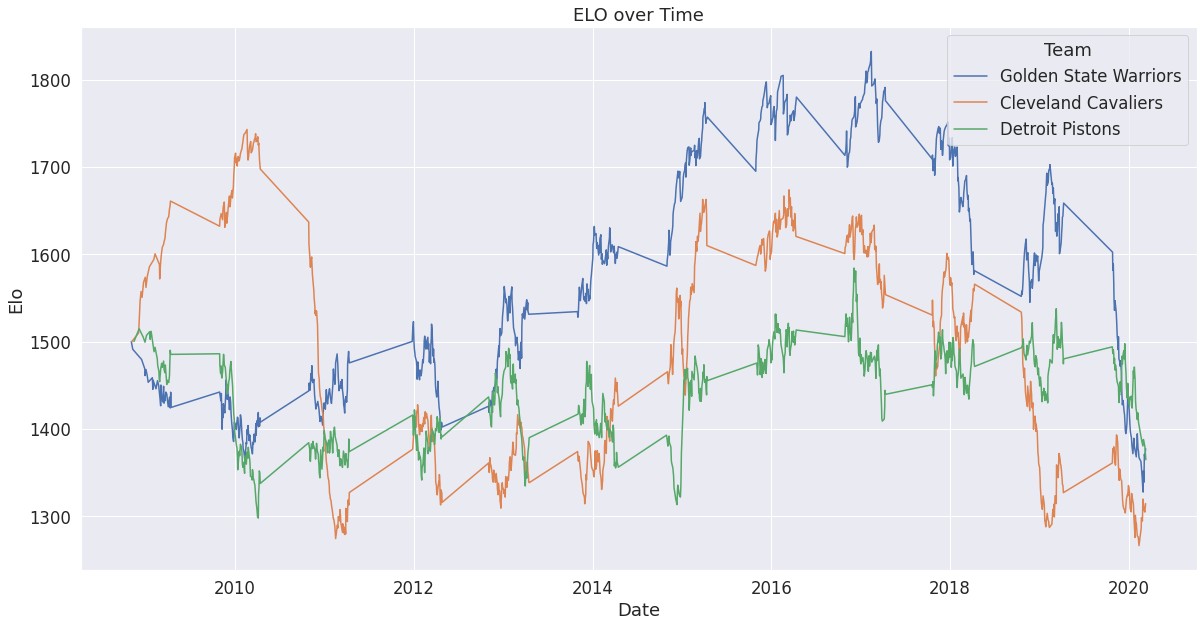

In [ ]:
%matplotlib inline
import random

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]
'''
for index, row in dataset.sample(frac=0.2).iterrows():
  sns.lineplot(data=row, x=dates, y=row.values)

plt.set(xlabel="Dates")
'''
elos = teams_elo_df['Elo'].values
#teams_elo_df['Elo_moving_average'] = runningMeanFast(elos, 15)
plt.figure(figsize=(20,10))
sample_teams = random.sample(list(teams), k=3)
sns.set(font_scale=1.5)
sampled_data = teams_elo_df.loc[teams_elo_df['Team'].isin(sample_teams)]
sns.lineplot(data=sampled_data, x='Date', y='Elo', hue='Team')
plt.title("ELO over Time")

## 3.2 Recent Team Performance 
Now, we will create another dataframe, **recent_perfomance_df**, that will contain the average performance of each team in their 10 most recent games. 

### Define function to get average stats of team from their 10 most recent games 
Given a team and a date, this function will return the given teams stats over the 10 previous games. 

In [ ]:
#given a team and a date, this method will return that teams average stats over the previous n games

def get_avg_stats_last_n_games(team, game_date, season_team_stats, n) :
  prev_game_df = season_team_stats[season_team_stats['Date'] < game_date][(season_team_stats['H_Team'] == team) | (season_team_stats['A_Team'] == team)].sort_values(by = 'Date').tail(n)

  h_df = prev_game_df.iloc[:, range(3, 43, 2)]
  h_df.columns = [x[2:] for x in h_df.columns]   
  a_df = prev_game_df.iloc[:, range(4, 44, 2)]
  a_df.columns = [x[2:] for x in a_df.columns] 
  
  df = pd.concat([h_df, a_df])
  df = df[df['Team'] == team]
  df.drop(columns = ['Team'], inplace=True)

  return df.mean()

### Calculate each teams recent performance

In [ ]:
recent_performance_df = pd.DataFrame()

for season in team_stats['Season'].unique() :
  l = ['Date', 'Game_ID', 'Season', 'H_Team', 'A_Team'] 
  other = list(team_stats.columns[9:47])  
  cols = l + other 

  season_team_stats = team_stats[team_stats['Season'] == season].sort_values(by = 'Date')[cols].reset_index(drop = True)

  season_recent_performance_df = pd.DataFrame()

  for index, row in season_team_stats.iterrows() : 
    game_id = row['Game_ID']
    game_date = row['Date']
    h_team = row['H_Team']
    a_team = row['A_Team']

    h_team_recent_performance = get_avg_stats_last_n_games(h_team, game_date, season_team_stats, 10)
    h_team_recent_performance.index = ['H_Last_10_Avg_' + x for x in h_team_recent_performance.index]

    a_team_recent_performance = get_avg_stats_last_n_games(a_team, game_date, season_team_stats, 10)
    a_team_recent_performance.index = ['A_Last_10_Avg_' + x for x in a_team_recent_performance.index]  
  
    new_row = pd.concat([h_team_recent_performance, a_team_recent_performance], sort=False)
    new_row['Game_ID'] = game_id

    season_recent_performance_df = season_recent_performance_df.append(new_row, ignore_index=True)
    season_recent_performance_df = season_recent_performance_df[new_row.index]


  recent_performance_df = pd.concat([recent_performance_df, season_recent_performance_df])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


View the output

In [ ]:
recent_performance_df.dropna()

,H_Last_10_Avg_Points,H_Last_10_Avg_Total_Rebounds,H_Last_10_Avg_Offensive_Rebounds,H_Last_10_Avg_Defensive_Rebounds,H_Last_10_Avg_Assists,H_Last_10_Avg_Turnovers,H_Last_10_Avg_Steals,H_Last_10_Avg_Blocks,H_Last_10_Avg_All_Free_Throws,H_Last_10_Avg_Live_Free_Throws,H_Last_10_Avg_FG_Attempts,H_Last_10_Avg_FG_Made,H_Last_10_Avg_FG_Missed,H_Last_10_Avg_2FG_Attempts,H_Last_10_Avg_2FG_Made,H_Last_10_Avg_2FG_Missed,H_Last_10_Avg_3FG_Attempts,H_Last_10_Avg_3FG_Made,H_Last_10_Avg_3FG_Missed,A_Last_10_Avg_Points,A_Last_10_Avg_Total_Rebounds,A_Last_10_Avg_Offensive_Rebounds,A_Last_10_Avg_Defensive_Rebounds,A_Last_10_Avg_Assists,A_Last_10_Avg_Turnovers,A_Last_10_Avg_Steals,A_Last_10_Avg_Blocks,A_Last_10_Avg_All_Free_Throws,A_Last_10_Avg_Live_Free_Throws,A_Last_10_Avg_FG_Attempts,A_Last_10_Avg_FG_Made,A_Last_10_Avg_FG_Missed,A_Last_10_Avg_2FG_Attempts,A_Last_10_Avg_2FG_Made,A_Last_10_Avg_2FG_Missed,A_Last_10_Avg_3FG_Attempts,A_Last_10_Avg_3FG_Made,A_Last_10_Avg_3FG_Missed,Game_ID
4,95.0,38.0,7.0,31.0,16.0,24.0,2.0,5.0,21.0,10.0,59.0,32.0,27.0,42.0,26.0,16.0,17.0,6.0,11.0,100.0,37.0,13.0,24.0,17.0,6.0,11.0,0.0,24.0,13.0,77.0,35.0,42.0,61.0,30.0,31.0,16.0,5.0,11.0,10607.0
7,103.0,28.0,6.0,22.0,21.0,12.0,5.0,6.0,24.0,13.0,73.0,37.0,36.0,58.0,31.0,27.0,15.0,6.0,9.0,90.0,47.0,11.0,36.0,22.0,15.0,7.0,4.0,21.0,11.0,77.0,35.0,42.0,68.0,31.0,37.0,9.0,4.0,5.0,10664.0
12,86.5,39.5,10.5,29.0,16.0,16.0,7.5,6.5,26.0,14.0,79.0,26.0,53.0,65.0,22.0,43.0,14.0,4.0,10.0,101.0,37.0,5.5,31.5,16.5,17.5,4.5,4.0,24.0,12.5,61.5,34.5,27.0,45.0,28.5,16.5,16.5,6.0,10.5,10690.0
17,101.5,32.0,7.5,24.5,22.5,14.5,6.5,3.0,23.5,13.0,74.0,38.0,36.0,60.5,31.5,29.0,13.5,6.5,7.0,79.0,48.0,17.0,31.0,15.0,12.0,7.0,5.0,14.0,6.0,96.0,33.0,63.0,76.0,30.0,46.0,20.0,3.0,17.0,10708.0
19,98.5,46.0,9.0,37.0,21.5,19.0,10.5,4.0,34.0,17.5,76.0,34.0,42.0,64.0,31.5,32.5,12.0,2.5,9.5,92.0,32.0,7.0,25.0,30.0,12.0,1.0,8.0,20.0,10.0,77.0,32.0,45.0,69.0,29.0,40.0,8.0,3.0,5.0,10712.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,109.4,47.0,10.5,36.5,24.8,15.4,7.4,4.7,23.0,12.1,88.3,40.3,48.0,54.2,28.8,25.4,34.1,11.5,22.6,116.1,49.7,9.0,40.7,24.5,16.4,6.6,3.9,26.3,14.3,88.3,40.9,47.4,46.8,27.0,19.8,41.5,13.9,27.6,732807.0
972,115.6,44.0,9.5,34.5,25.0,13.8,7.5,3.5,26.4,13.6,85.9,41.3,44.6,54.8,30.0,24.8,31.1,11.3,19.8,114.2,45.0,10.7,34.3,27.5,18.2,7.4,3.9,25.9,14.0,88.9,42.2,46.7,56.4,30.7,25.7,32.5,11.5,21.0,732808.0
973,111.0,45.2,7.3,37.9,24.2,15.5,9.2,4.5,28.4,14.5,82.5,37.2,45.3,44.1,23.0,21.1,38.4,14.2,24.2,110.6,41.7,10.7,31.0,27.9,14.6,7.3,3.8,17.8,10.2,86.0,42.5,43.5,54.7,31.0,23.7,31.3,11.5,19.8,732814.0
974,110.4,42.6,7.7,34.9,24.0,13.6,8.1,6.1,19.8,10.8,87.7,42.0,45.7,58.8,31.5,27.3,28.9,10.5,18.4,109.9,42.3,7.8,34.5,26.9,14.6,8.7,5.8,24.4,12.7,82.4,38.1,44.3,43.9,24.3,19.6,38.5,13.8,24.7,732812.0


## 3.3 Combine the extracted team stats features into **final_team_stats**
Below we combine the features we just created into a dataframe called final_team_stats. This data frame includes all the meta data for each game, the elo ratings for the home and away team, and the home and away teams previous stats over the past 10 games.

In [ ]:
final_team_stats = team_stats.iloc[0:, [0,1,2,3,4,9,10]].merge(elo_df.drop(columns=['H_Team', 'A_Team']), on = 'Game_ID') \
                                     .merge(recent_performance_df, on = 'Game_ID')

final_team_stats = final_team_stats.dropna()

final_team_stats.head(5)

,Date,Game_ID,Season,H_Team,A_Team,H_Points,A_Points,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After,H_Last_10_Avg_Points,H_Last_10_Avg_Total_Rebounds,H_Last_10_Avg_Offensive_Rebounds,H_Last_10_Avg_Defensive_Rebounds,H_Last_10_Avg_Assists,H_Last_10_Avg_Turnovers,H_Last_10_Avg_Steals,H_Last_10_Avg_Blocks,H_Last_10_Avg_All_Free_Throws,H_Last_10_Avg_Live_Free_Throws,H_Last_10_Avg_FG_Attempts,H_Last_10_Avg_FG_Made,H_Last_10_Avg_FG_Missed,H_Last_10_Avg_2FG_Attempts,H_Last_10_Avg_2FG_Made,H_Last_10_Avg_2FG_Missed,H_Last_10_Avg_3FG_Attempts,H_Last_10_Avg_3FG_Made,H_Last_10_Avg_3FG_Missed,A_Last_10_Avg_Points,A_Last_10_Avg_Total_Rebounds,A_Last_10_Avg_Offensive_Rebounds,A_Last_10_Avg_Defensive_Rebounds,A_Last_10_Avg_Assists,A_Last_10_Avg_Turnovers,A_Last_10_Avg_Steals,A_Last_10_Avg_Blocks,A_Last_10_Avg_All_Free_Throws,A_Last_10_Avg_Live_Free_Throws,A_Last_10_Avg_FG_Attempts,A_Last_10_Avg_FG_Made,A_Last_10_Avg_FG_Missed,A_Last_10_Avg_2FG_Attempts,A_Last_10_Avg_2FG_Made,A_Last_10_Avg_2FG_Missed,A_Last_10_Avg_3FG_Attempts,A_Last_10_Avg_3FG_Made,A_Last_10_Avg_3FG_Missed
4,2008-11-01,10607,2008 - 2009,Phoenix Suns,Portland Trail Blazers,107,96,1485.35,1503.25,1494.885532,1493.709388,95.0,38.0,7.0,31.0,16.0,24.0,2.0,5.0,21.0,10.0,59.0,32.0,27.0,42.0,26.0,16.0,17.0,6.0,11.0,100.0,37.0,13.0,24.0,17.0,6.0,11.0,0.0,24.0,13.0,77.0,35.0,42.0,61.0,30.0,31.0,16.0,5.0,11.0
7,2008-11-05,10664,2008 - 2009,Sacramento Kings,Memphis Grizzlies,100,95,1487.76,1508.85,1493.932569,1502.675362,103.0,28.0,6.0,22.0,21.0,12.0,5.0,6.0,24.0,13.0,73.0,37.0,36.0,58.0,31.0,27.0,15.0,6.0,9.0,90.0,47.0,11.0,36.0,22.0,15.0,7.0,4.0,21.0,11.0,77.0,35.0,42.0,68.0,31.0,37.0,9.0,4.0,5.0
11,2008-11-07,10690,2008 - 2009,Chicago Bulls,Phoenix Suns,100,83,1478.85,1494.89,1491.439045,1482.292058,86.5,39.5,10.5,29.0,16.0,16.0,7.5,6.5,26.0,14.0,79.0,26.0,53.0,65.0,22.0,43.0,14.0,4.0,10.0,101.0,37.0,5.5,31.5,16.5,17.5,4.5,4.0,24.0,12.5,61.5,34.5,27.0,45.0,28.5,16.5,16.5,6.0,10.5
17,2008-11-09,10708,2008 - 2009,Sacramento Kings,Golden State Warriors,115,98,1493.93,1491.15,1505.570065,1479.509669,101.5,32.0,7.5,24.5,22.5,14.5,6.5,3.0,23.5,13.0,74.0,38.0,36.0,60.5,31.5,29.0,13.5,6.5,7.0,79.0,48.0,17.0,31.0,15.0,12.0,7.0,5.0,14.0,6.0,96.0,33.0,63.0,76.0,30.0,46.0,20.0,3.0,17.0
19,2008-11-10,10712,2008 - 2009,Boston Celtics,Toronto Raptors,94,87,1520.22,1487.76,1526.086831,1481.884018,98.5,46.0,9.0,37.0,21.5,19.0,10.5,4.0,34.0,17.5,76.0,34.0,42.0,64.0,31.5,32.5,12.0,2.5,9.5,92.0,32.0,7.0,25.0,30.0,12.0,1.0,8.0,20.0,10.0,77.0,32.0,45.0,69.0,29.0,40.0,8.0,3.0,5.0


In addition, lets create another dataframe that uses team-by-team rows so we can better group and understand changes in data on per team basis – combining team stats with the team_elo dataframe we created earlier. Because the initially scraped data contains rows that are the outcomes of games for both teams as opposed to each: this will require some more processing.

In [ ]:
home_cols = final_team_stats.columns[final_team_stats.columns.str.startswith('H_')]

team_df = final_team_stats.iloc[0:, [0,1,2,3,4,9,10]].drop(columns=['H_Team', 'A_Team'])
team_df_home = team_df.drop(columns=team_df.columns[team_df.columns.str.startswith('A_')])
team_df_away = team_df.drop(columns=team_df.columns[team_df.columns.str.startswith('H_')])

recent_performance_home = recent_performance_df.drop(columns=recent_performance_df.columns \
                                                     [recent_performance_df.columns.str.startswith('A_')])
recent_performance_away = recent_performance_df.drop(columns=recent_performance_df.columns \
                                                     [recent_performance_df.columns.str.startswith('H_')])

team_by_team_home = team_df_home.merge(teams_elo_df[teams_elo_df.Where_Played == "Home"], on = 'Game_ID') \
                                     .merge(recent_performance_home, on = 'Game_ID')
team_by_team_away = team_df_away.merge(teams_elo_df[teams_elo_df.Where_Played == "Away"], on = 'Game_ID') \
                                     .merge(recent_performance_away, on = 'Game_ID')

team_by_team_home.columns = team_by_team_home.columns.str.replace("H_", "")
team_by_team_away.columns = team_by_team_away.columns.str.replace("A_", "")
team_by_team_home.columns = team_by_team_home.columns.str.replace("_y", "")
team_by_team_home.columns = team_by_team_home.columns.str.replace("_x", "")
team_by_team_home = team_by_team_home.loc[:,~team_by_team_home.columns.duplicated()]

team_by_team_away.columns = team_by_team_away.columns.str.replace("_y", "")
team_by_team_away.columns = team_by_team_away.columns.str.replace("_x", "")
team_by_team_away = team_by_team_away.loc[:,~team_by_team_away.columns.duplicated()]

team_performances_df = pd.concat([team_by_team_home, team_by_team_away]).sort_index(axis=0).reset_index().drop(columns=['index'])
#team_performances_df = team_performances_df.drop(columns=['Date_x', 'Season_x'])
#team_performances_df.columns = team_performances_df.columns.str.replace("_y", "")
#team_performances_df.columns = team_performances_df.columns.str.replace("_x", "")
#team_performances_df = team_performances_df.loc[:,~team_performances_df.columns.duplicated()]


In [ ]:
team_performances_df

,Date,Game_ID,Season,Last_10_Avg_Points,Last_10_Avg_Total_Rebounds,Team,Elo,Where_Played,Last_10_Avg_Offensive_Rebounds,Last_10_Avg_Defensive_Rebounds,Last_10_Avg_Assists,Last_10_Avg_Turnovers,Last_10_Avg_Steals,Last_10_Avg_Blocks,Last_10_Avg_All_Free_Throws,Last_10_Avg_Live_Free_Throws,Last_10_Avg_FG_Attempts,Last_10_Avg_FG_Made,Last_10_Avg_FG_Missed,Last_10_Avg_2FG_Attempts,Last_10_Avg_2FG_Made,Last_10_Avg_2FG_Missed,Last_10_Avg_3FG_Attempts,Last_10_Avg_3FG_Made,Last_10_Avg_3FG_Missed
0,2008-11-01,10607,2008 - 2009,95.0,38.0,Phoenix Suns,1485.345335,Home,7.0,31.0,16.0,24.0,2.0,5.0,21.0,10.0,59.0,32.0,27.0,42.0,26.0,16.0,17.0,6.0,11.0
1,2008-11-01,10607,2008 - 2009,100.0,37.0,Portland Trail Blazers,1503.249585,Away,13.0,24.0,17.0,6.0,11.0,0.0,24.0,13.0,77.0,35.0,42.0,61.0,30.0,31.0,16.0,5.0,11.0
2,2008-11-05,10664,2008 - 2009,103.0,28.0,Sacramento Kings,1487.755097,Home,6.0,22.0,21.0,12.0,5.0,6.0,24.0,13.0,73.0,37.0,36.0,58.0,31.0,27.0,15.0,6.0,9.0
3,2008-11-05,10664,2008 - 2009,90.0,47.0,Memphis Grizzlies,1508.852834,Away,11.0,36.0,22.0,15.0,7.0,4.0,21.0,11.0,77.0,35.0,42.0,68.0,31.0,37.0,9.0,4.0,5.0
4,2008-11-07,10690,2008 - 2009,86.5,39.5,Chicago Bulls,1478.845571,Home,10.5,29.0,16.0,16.0,7.5,6.5,26.0,14.0,79.0,26.0,53.0,65.0,22.0,43.0,14.0,4.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24797,2020-08-14,732814,2019 - 2020,111.0,45.2,Toronto Raptors,1688.425706,Home,7.3,37.9,24.2,15.5,9.2,4.5,28.4,14.5,82.5,37.2,45.3,44.1,23.0,21.1,38.4,14.2,24.2
24798,2020-08-14,732812,2019 - 2020,109.9,42.3,Miami Heat,1565.550112,Away,7.8,34.5,26.9,14.6,8.7,5.8,24.4,12.7,82.4,38.1,44.3,43.9,24.3,19.6,38.5,13.8,24.7
24799,2020-08-14,732812,2019 - 2020,110.4,42.6,Indiana Pacers,1561.235463,Home,7.7,34.9,24.0,13.6,8.1,6.1,19.8,10.8,87.7,42.0,45.7,58.8,31.5,27.3,28.9,10.5,18.4
24800,2020-08-14,732811,2019 - 2020,110.0,40.7,Houston Rockets,1562.015343,Home,7.7,33.0,21.7,15.5,9.8,4.3,26.3,13.1,86.8,36.7,50.1,38.0,21.2,16.8,48.8,15.5,33.3


## 3.4 Add a label column and save to csv
The last thing we need to add to our data is a label column which will be the winner of the game. This column will be 1 if the home team wins and 0 otherwise

In [ ]:
final_team_stats['Label'] = [1 if x > 0 else 0 for x in final_team_stats['H_Points'] - final_team_stats['A_Points']]
final_team_stats.drop(columns=['H_Points', 'A_Points'], inplace=True)
final_team_stats = final_team_stats.dropna()

combined_copy = final_team_stats

final_team_stats

In [ ]:
final_team_stats.to_csv('/content/drive/MyDrive/CIS545 Final Project/Final_Team_Stats.csv')

## 3.5 Recent Player Performance 
Now, for each row of data that we scaped for player statistics, we calulate that players average performance in their previous 10 games. We will save this data to a dataframe called **player_recent_performance_df**

### Read in the player stats data

In [ ]:
player_stats = pd.read_csv('/content/drive/MyDrive/CIS545 Final Project/NBA_Combined_Player_Stats.csv', index_col = 0)
player_stats = player_stats.sort_values(by = 'Date').reset_index(drop = True)

In [ ]:
player_stats['Min'] = player_stats['Min'].apply(lambda x: float(x.split(':')[0]) + float(x.split(':')[1]) / 60)
player_stats['PPP'] = player_stats['PPP'].apply(lambda x: '0' if x == '-' else x)
player_stats['PPP'] = player_stats['PPP'].astype(float)

### Define a function that gets the average stats of a player in their previous 10 games 

In [ ]:
def rolling_average_last_n_games(n) :
  player_stats_recent_performance_df = pd.DataFrame()

  for season in player_stats['Season'].unique() :
    season_player_stats = player_stats[player_stats['Season'] == season]

    for player in season_player_stats['PlayerName'].unique() : 
      player_recent_performance = season_player_stats[season_player_stats['PlayerName'] == player].rolling(n, min_periods=1).mean().shift(1)

      player_stats_recent_performance_df = player_stats_recent_performance_df.append(player_recent_performance, ignore_index=False)
  
  player_stats_recent_performance_df.columns = ['Last_' + str(n) + '_Avg_' + x for x in player_stats_recent_performance_df.columns]
  player_stats_recent_performance_df = player_stats[['PlayerName', 'GameID']].merge(player_stats_recent_performance_df.drop(columns='Last_' + str(n) + '_Avg_' + 'GameID'), left_index=True, right_index=True)

  return player_stats_recent_performance_df


### Calculate each players recent perfomance 
For each entry that we have in our player stats data, we will caclulate that players recent perfomance in their previous 10 games. If they haven't played 10 games yet, then we will average all the games they have played so far. This will be saved to the dataframe **recent_performance_df**.

In [ ]:
player_recent_performance_df = rolling_average_last_n_games(10)

player_recent_performance_df

,PlayerName,GameID,Last_10_Avg_Min,Last_10_Avg_SST,Last_10_Avg_Pts,Last_10_Avg_PPP,Last_10_Avg_Ast,Last_10_Avg_T/O,Last_10_Avg_Ast/TO,Last_10_Avg_Stl,Last_10_Avg_StlPos,Last_10_Avg_Blk,Last_10_Avg_BlkFGA,Last_10_Avg_TtlReb,Last_10_Avg_OffReb,Last_10_Avg_DefReb,Last_10_Avg_FGA,Last_10_Avg_FGM,Last_10_Avg_FGm,Last_10_Avg_2FGA,Last_10_Avg_2FGM,Last_10_Avg_2FGm,Last_10_Avg_3FGA,Last_10_Avg_3FGM,Last_10_Avg_3FGm,Last_10_Avg_FTA,Last_10_Avg_FTM,Last_10_Avg_FTm,Last_10_Avg_PFTkn,Last_10_Avg_PFCom
0,Rasual Butler,10587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hilton Armstrong,10587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,James Posey,10587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,David West,10587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Morris Peterson,10587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290092,Matisse Thybulle,732811,21.486667,0.656000,4.8,1.040,1.300000,0.700000,0.750,1.3,0.300000,0.500000,0.0,2.200000,1.1,1.100000,4.000000,2.000000,2.0,2.000000,1.300000,0.700000,2.0,0.700000,1.300000,0.200000,0.100000,0.100000,0.200000,2.3
290093,Reggie Jackson,732813,22.166667,0.930000,9.9,1.008,2.700000,1.500000,1.116,0.3,0.600000,0.100000,0.5,2.800000,0.2,2.600000,8.000000,3.600000,4.4,4.300000,2.000000,2.300000,3.7,1.600000,2.100000,1.300000,1.100000,0.200000,1.400000,2.2
290094,Marial Shayok,732811,6.638889,0.596667,2.0,0.450,0.333333,0.666667,0.000,0.0,0.333333,0.333333,0.0,1.666667,0.0,1.666667,2.666667,0.666667,2.0,1.666667,0.333333,1.333333,1.0,0.333333,0.666667,0.666667,0.333333,0.333333,0.333333,1.0
290095,Monte Morris,732814,26.748333,0.953000,11.2,1.051,2.800000,0.700000,0.967,0.4,0.600000,0.200000,0.7,2.000000,0.4,1.600000,8.900000,4.000000,4.9,6.100000,2.900000,3.200000,2.8,1.100000,1.700000,2.400000,2.100000,0.300000,1.700000,1.0


## 3.6 Player Season Average Perfomance
Now, we calulate each players season average up until the current game that is being played. This data will be saved to the dataframe **avg_season_stats**

In [ ]:
avg_season_stats = pd.DataFrame() 

for season in player_stats['Season'].unique() :
  season_player_stats = player_stats[player_stats['Season'] == season]
  for player in season_player_stats['PlayerName'].unique() : 
    player_avg_season_stats = season_player_stats[season_player_stats['PlayerName'] == player].expanding().mean().shift(1)

    avg_season_stats = avg_season_stats.append(player_avg_season_stats, ignore_index=False)
  

avg_season_stats.drop(columns= 'GameID', inplace = True)
avg_season_stats.columns = ['Avg_Season_' + x for x in avg_season_stats.columns]
avg_season_stats = player_stats.iloc[:, 0:6].merge(avg_season_stats, left_index = True, right_index = True)

In [ ]:
avg_season_stats

,PlayerName,PlayerTeam,OpposingTeam,Date,GameID,Season,Avg_Season_Min,Avg_Season_SST,Avg_Season_Pts,Avg_Season_PPP,Avg_Season_Ast,Avg_Season_T/O,Avg_Season_Ast/TO,Avg_Season_Stl,Avg_Season_StlPos,Avg_Season_Blk,Avg_Season_BlkFGA,Avg_Season_TtlReb,Avg_Season_OffReb,Avg_Season_DefReb,Avg_Season_FGA,Avg_Season_FGM,Avg_Season_FGm,Avg_Season_2FGA,Avg_Season_2FGM,Avg_Season_2FGm,Avg_Season_3FGA,Avg_Season_3FGM,Avg_Season_3FGm,Avg_Season_FTA,Avg_Season_FTM,Avg_Season_FTm,Avg_Season_PFTkn,Avg_Season_PFCom
0,Rasual Butler,New Orleans Pelicans,Phoenix Suns,2008-10-30,10587,2008 - 2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hilton Armstrong,New Orleans Pelicans,Phoenix Suns,2008-10-30,10587,2008 - 2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,James Posey,New Orleans Pelicans,Phoenix Suns,2008-10-30,10587,2008 - 2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,David West,New Orleans Pelicans,Phoenix Suns,2008-10-30,10587,2008 - 2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Morris Peterson,New Orleans Pelicans,Phoenix Suns,2008-10-30,10587,2008 - 2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290092,Matisse Thybulle,Philadelphia 76ers,Houston Rockets,2020-08-14,732811,2019 - 2020,19.807143,0.650000,4.682540,0.950000,1.222222,0.777778,0.555556,1.380952,0.396825,0.682540,0.126984,1.650794,0.682540,0.968254,4.063492,1.714286,2.349206,1.650794,0.857143,0.793651,2.412698,0.857143,1.555556,0.650794,0.396825,0.253968,0.666667,2.142857
290093,Reggie Jackson,Los Angeles Clippers,Oklahoma City Thunder,2020-08-14,732813,2019 - 2020,24.665476,1.163214,12.607143,0.976071,4.107143,1.678571,2.065357,0.464286,0.964286,0.178571,0.571429,3.035714,0.571429,2.464286,10.964286,4.571429,6.392857,6.107143,2.607143,3.500000,4.857143,1.964286,2.892857,1.821429,1.500000,0.321429,1.714286,1.928571
290094,Marial Shayok,Philadelphia 76ers,Houston Rockets,2020-08-14,732811,2019 - 2020,6.638889,0.596667,2.000000,0.450000,0.333333,0.666667,0.000000,0.000000,0.333333,0.333333,0.000000,1.666667,0.000000,1.666667,2.666667,0.666667,2.000000,1.666667,0.333333,1.333333,1.000000,0.333333,0.666667,0.666667,0.333333,0.333333,0.333333,1.000000
290095,Monte Morris,Denver Nuggets,Toronto Raptors,2020-08-14,732814,2019 - 2020,22.426291,1.008732,8.985915,0.996338,3.492958,0.704225,1.608028,0.774648,0.450704,0.225352,0.394366,1.830986,0.338028,1.492958,7.690141,3.577465,4.112676,5.366197,2.690141,2.676056,2.323944,0.887324,1.436620,1.140845,0.943662,0.197183,1.084507,1.028169


## 3.7 Combine the extracted player stats features into **final_player_stats**

In [ ]:
final_player_stats = avg_season_stats.merge(player_recent_performance_df.drop(columns = ['GameID', 'PlayerName']), left_index=True, right_index=True)
final_player_stats = final_player_stats.dropna()

In [ ]:
final_player_stats.to_csv('/content/drive/MyDrive/CIS545 Final Project/Final_Player_Stats.csv')

## 3.8 Display our final data

In [ ]:
final_team_stats

,Date,Game_ID,Season,H_Team,A_Team,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After,H_Last_10_Avg_Points,H_Last_10_Avg_Total_Rebounds,H_Last_10_Avg_Offensive_Rebounds,H_Last_10_Avg_Defensive_Rebounds,H_Last_10_Avg_Assists,H_Last_10_Avg_Turnovers,H_Last_10_Avg_Steals,H_Last_10_Avg_Blocks,H_Last_10_Avg_All_Free_Throws,H_Last_10_Avg_Live_Free_Throws,H_Last_10_Avg_FG_Attempts,H_Last_10_Avg_FG_Made,H_Last_10_Avg_FG_Missed,H_Last_10_Avg_2FG_Attempts,H_Last_10_Avg_2FG_Made,H_Last_10_Avg_2FG_Missed,H_Last_10_Avg_3FG_Attempts,H_Last_10_Avg_3FG_Made,H_Last_10_Avg_3FG_Missed,A_Last_10_Avg_Points,A_Last_10_Avg_Total_Rebounds,A_Last_10_Avg_Offensive_Rebounds,A_Last_10_Avg_Defensive_Rebounds,A_Last_10_Avg_Assists,A_Last_10_Avg_Turnovers,A_Last_10_Avg_Steals,A_Last_10_Avg_Blocks,A_Last_10_Avg_All_Free_Throws,A_Last_10_Avg_Live_Free_Throws,A_Last_10_Avg_FG_Attempts,A_Last_10_Avg_FG_Made,A_Last_10_Avg_FG_Missed,A_Last_10_Avg_2FG_Attempts,A_Last_10_Avg_2FG_Made,A_Last_10_Avg_2FG_Missed,A_Last_10_Avg_3FG_Attempts,A_Last_10_Avg_3FG_Made,A_Last_10_Avg_3FG_Missed,Label
4,2008-11-01,10607,2008 - 2009,Phoenix Suns,Portland Trail Blazers,1485.35,1503.25,1494.885532,1493.709388,95.0,38.0,7.0,31.0,16.0,24.0,2.0,5.0,21.0,10.0,59.0,32.0,27.0,42.0,26.0,16.0,17.0,6.0,11.0,100.0,37.0,13.0,24.0,17.0,6.0,11.0,0.0,24.0,13.0,77.0,35.0,42.0,61.0,30.0,31.0,16.0,5.0,11.0,1
7,2008-11-05,10664,2008 - 2009,Sacramento Kings,Memphis Grizzlies,1487.76,1508.85,1493.932569,1502.675362,103.0,28.0,6.0,22.0,21.0,12.0,5.0,6.0,24.0,13.0,73.0,37.0,36.0,58.0,31.0,27.0,15.0,6.0,9.0,90.0,47.0,11.0,36.0,22.0,15.0,7.0,4.0,21.0,11.0,77.0,35.0,42.0,68.0,31.0,37.0,9.0,4.0,5.0,1
12,2008-11-07,10690,2008 - 2009,Chicago Bulls,Phoenix Suns,1478.85,1494.89,1491.439045,1482.292058,86.5,39.5,10.5,29.0,16.0,16.0,7.5,6.5,26.0,14.0,79.0,26.0,53.0,65.0,22.0,43.0,14.0,4.0,10.0,101.0,37.0,5.5,31.5,16.5,17.5,4.5,4.0,24.0,12.5,61.5,34.5,27.0,45.0,28.5,16.5,16.5,6.0,10.5,1
17,2008-11-09,10708,2008 - 2009,Sacramento Kings,Golden State Warriors,1493.93,1491.15,1505.570065,1479.509669,101.5,32.0,7.5,24.5,22.5,14.5,6.5,3.0,23.5,13.0,74.0,38.0,36.0,60.5,31.5,29.0,13.5,6.5,7.0,79.0,48.0,17.0,31.0,15.0,12.0,7.0,5.0,14.0,6.0,96.0,33.0,63.0,76.0,30.0,46.0,20.0,3.0,17.0,1
19,2008-11-10,10712,2008 - 2009,Boston Celtics,Toronto Raptors,1520.22,1487.76,1526.086831,1481.884018,98.5,46.0,9.0,37.0,21.5,19.0,10.5,4.0,34.0,17.5,76.0,34.0,42.0,64.0,31.5,32.5,12.0,2.5,9.5,92.0,32.0,7.0,25.0,30.0,12.0,1.0,8.0,20.0,10.0,77.0,32.0,45.0,69.0,29.0,40.0,8.0,3.0,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12620,2020-08-13,732809,2019 - 2020,Phoenix Suns,Dallas Mavericks,1550.38,1569.67,1567.563260,1552.492828,122.2,46.9,10.0,36.9,27.2,12.8,6.4,3.8,23.3,12.4,89.4,43.4,46.0,55.2,29.5,25.7,34.2,13.9,20.3,114.9,44.1,8.4,35.7,25.2,11.4,7.5,4.8,22.2,12.0,89.3,41.8,47.5,49.5,27.9,21.6,39.8,13.9,25.9,1
12621,2020-08-13,732808,2019 - 2020,Orlando Magic,New Orleans Pelicans,1484.61,1511.43,1491.555731,1504.480226,115.6,44.0,9.5,34.5,25.0,13.8,7.5,3.5,26.4,13.6,85.9,41.3,44.6,54.8,30.0,24.8,31.1,11.3,19.8,114.2,45.0,10.7,34.3,27.5,18.2,7.4,3.9,25.9,14.0,88.9,42.2,46.7,56.4,30.7,25.7,32.5,11.5,21.0,1
12622,2020-08-14,732812,2019 - 2020,Indiana Pacers,Miami Heat,1561.24,1565.55,1573.228353,1553.557222,110.4,42.6,7.7,34.9,24.0,13.6,8.1,6.1,19.8,10.8,87.7,42.0,45.7,58.8,31.5,27.3,28.9,10.5,18.4,109.9,42.3,7.8,34.5,26.9,14.6,8.7,5.8,24.4,12.7,82.4,38.1,44.3,43.9,24.3,19.6,38.5,13.8,24.7,1
12623,2020-08-14,732814,2019 - 2020,Toronto Raptors,Denver Nuggets,1688.43,1541.69,1692.067737,1538.049789,111.0,45.2,7.3,37.9,24.2,15.5,9.2,4.5,28.4,14.5,82.5,37.2,45.3,44.1,23.0,21.1,38.4,14.2,24.2,110.6,41.7,10.7,31.0,27.9,14.6,7.3,3.8,17.8,10.2,86.0,42.5,43.5,54.7,31.0,23.7,31.3,11.5,19.8,1


In [ ]:
final_player_stats

,PlayerName,PlayerTeam,OpposingTeam,Date,GameID,Season,Avg_Season_Min,Avg_Season_SST,Avg_Season_Pts,Avg_Season_PPP,Avg_Season_Ast,Avg_Season_T/O,Avg_Season_Ast/TO,Avg_Season_Stl,Avg_Season_StlPos,Avg_Season_Blk,Avg_Season_BlkFGA,Avg_Season_TtlReb,Avg_Season_OffReb,Avg_Season_DefReb,Avg_Season_FGA,Avg_Season_FGM,Avg_Season_FGm,Avg_Season_2FGA,Avg_Season_2FGM,Avg_Season_2FGm,Avg_Season_3FGA,Avg_Season_3FGM,Avg_Season_3FGm,Avg_Season_FTA,Avg_Season_FTM,Avg_Season_FTm,Avg_Season_PFTkn,Avg_Season_PFCom,Last_10_Avg_Min,Last_10_Avg_SST,Last_10_Avg_Pts,Last_10_Avg_PPP,Last_10_Avg_Ast,Last_10_Avg_T/O,Last_10_Avg_Ast/TO,Last_10_Avg_Stl,Last_10_Avg_StlPos,Last_10_Avg_Blk,Last_10_Avg_BlkFGA,Last_10_Avg_TtlReb,Last_10_Avg_OffReb,Last_10_Avg_DefReb,Last_10_Avg_FGA,Last_10_Avg_FGM,Last_10_Avg_FGm,Last_10_Avg_2FGA,Last_10_Avg_2FGM,Last_10_Avg_2FGm,Last_10_Avg_3FGA,Last_10_Avg_3FGM,Last_10_Avg_3FGm,Last_10_Avg_FTA,Last_10_Avg_FTM,Last_10_Avg_FTm,Last_10_Avg_PFTkn,Last_10_Avg_PFCom
142,Leon Powe,Boston Celtics,Indiana Pacers,2008-11-01,10597,2008 - 2009,18.000000,2.210000,13.000000,1.000000,1.000000,3.000000,0.330000,0.000000,1.000000,0.000000,0.000000,6.000000,1.000000,5.000000,6.000000,3.000000,3.000000,6.000000,3.000000,3.000000,0.000000,0.000000,0.000000,10.000000,7.000000,3.000000,5.000000,0.000000,18.000000,2.210000,13.0,1.000,1.000000,3.000000,0.330,0.0,1.000000,0.000000,0.0,6.000000,1.0,5.000000,6.000000,3.000000,3.0,6.000000,3.000000,3.000000,0.0,0.000000,0.000000,10.000000,7.000000,3.000000,5.000000,0.0
151,Kevin Garnett,Boston Celtics,Indiana Pacers,2008-11-01,10597,2008 - 2009,26.000000,2.140000,18.000000,1.290000,3.000000,3.000000,1.000000,2.000000,1.000000,2.000000,0.000000,10.000000,1.000000,9.000000,11.000000,7.000000,4.000000,11.000000,7.000000,4.000000,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,5.000000,0.000000,26.000000,2.140000,18.0,1.290,3.000000,3.000000,1.000,2.0,1.000000,2.000000,0.0,10.000000,1.0,9.000000,11.000000,7.000000,4.0,11.000000,7.000000,4.000000,0.0,0.000000,0.000000,4.000000,4.000000,0.000000,5.000000,0.0
153,Rajon Rondo,Boston Celtics,Indiana Pacers,2008-11-01,10597,2008 - 2009,29.000000,1.510000,14.000000,0.880000,6.000000,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000,3.000000,8.000000,4.000000,4.000000,8.000000,4.000000,4.000000,0.000000,0.000000,0.000000,11.000000,6.000000,5.000000,7.000000,0.000000,29.000000,1.510000,14.0,0.880,6.000000,3.000000,2.000,1.0,1.000000,0.000000,0.0,3.000000,0.0,3.000000,8.000000,4.000000,4.0,8.000000,4.000000,4.000000,0.0,0.000000,0.000000,11.000000,6.000000,5.000000,7.000000,0.0
154,Brandon Roy,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,34.000000,2.090000,26.000000,1.180000,7.000000,1.000000,7.000000,3.000000,0.000000,0.000000,0.000000,5.000000,1.000000,4.000000,18.000000,10.000000,8.000000,15.000000,9.000000,6.000000,3.000000,1.000000,2.000000,7.000000,5.000000,2.000000,5.000000,0.000000,34.000000,2.090000,26.0,1.180,7.000000,1.000000,7.000,3.0,0.000000,0.000000,0.0,5.000000,1.0,4.000000,18.000000,10.000000,8.0,15.000000,9.000000,6.000000,3.0,1.000000,2.000000,7.000000,5.000000,2.000000,5.000000,0.0
155,Gabe Pruitt,Boston Celtics,Indiana Pacers,2008-11-01,10597,2008 - 2009,6.000000,1.110000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.110000,3.0,3.000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.0,1.000000,1.0,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290092,Matisse Thybulle,Philadelphia 76er

In [ ]:
team_performances_df

,Date,Game_ID,Season,Last_10_Avg_Points,Last_10_Avg_Total_Rebounds,Team,Elo,Where_Played,Last_10_Avg_Offensive_Rebounds,Last_10_Avg_Defensive_Rebounds,Last_10_Avg_Assists,Last_10_Avg_Turnovers,Last_10_Avg_Steals,Last_10_Avg_Blocks,Last_10_Avg_All_Free_Throws,Last_10_Avg_Live_Free_Throws,Last_10_Avg_FG_Attempts,Last_10_Avg_FG_Made,Last_10_Avg_FG_Missed,Last_10_Avg_2FG_Attempts,Last_10_Avg_2FG_Made,Last_10_Avg_2FG_Missed,Last_10_Avg_3FG_Attempts,Last_10_Avg_3FG_Made,Last_10_Avg_3FG_Missed
0,2008-11-01,10607,2008 - 2009,95.0,38.0,Phoenix Suns,1485.345335,Home,7.0,31.0,16.0,24.0,2.0,5.0,21.0,10.0,59.0,32.0,27.0,42.0,26.0,16.0,17.0,6.0,11.0
1,2008-11-01,10607,2008 - 2009,100.0,37.0,Portland Trail Blazers,1503.249585,Away,13.0,24.0,17.0,6.0,11.0,0.0,24.0,13.0,77.0,35.0,42.0,61.0,30.0,31.0,16.0,5.0,11.0
2,2008-11-05,10664,2008 - 2009,103.0,28.0,Sacramento Kings,1487.755097,Home,6.0,22.0,21.0,12.0,5.0,6.0,24.0,13.0,73.0,37.0,36.0,58.0,31.0,27.0,15.0,6.0,9.0
3,2008-11-05,10664,2008 - 2009,90.0,47.0,Memphis Grizzlies,1508.852834,Away,11.0,36.0,22.0,15.0,7.0,4.0,21.0,11.0,77.0,35.0,42.0,68.0,31.0,37.0,9.0,4.0,5.0
4,2008-11-07,10690,2008 - 2009,86.5,39.5,Chicago Bulls,1478.845571,Home,10.5,29.0,16.0,16.0,7.5,6.5,26.0,14.0,79.0,26.0,53.0,65.0,22.0,43.0,14.0,4.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24797,2020-08-14,732814,2019 - 2020,111.0,45.2,Toronto Raptors,1688.425706,Home,7.3,37.9,24.2,15.5,9.2,4.5,28.4,14.5,82.5,37.2,45.3,44.1,23.0,21.1,38.4,14.2,24.2
24798,2020-08-14,732812,2019 - 2020,109.9,42.3,Miami Heat,1565.550112,Away,7.8,34.5,26.9,14.6,8.7,5.8,24.4,12.7,82.4,38.1,44.3,43.9,24.3,19.6,38.5,13.8,24.7
24799,2020-08-14,732812,2019 - 2020,110.4,42.6,Indiana Pacers,1561.235463,Home,7.7,34.9,24.0,13.6,8.1,6.1,19.8,10.8,87.7,42.0,45.7,58.8,31.5,27.3,28.9,10.5,18.4
24800,2020-08-14,732811,2019 - 2020,110.0,40.7,Houston Rockets,1562.015343,Home,7.7,33.0,21.7,15.5,9.8,4.3,26.3,13.1,86.8,36.7,50.1,38.0,21.2,16.8,48.8,15.5,33.3


# Section 4: Exploratory Data Analysis

## 4.1 Process win data in team_performances_df
Before we proceed, let's amend the win column of team_performance_df to mirror final_team_stats

In [ ]:
labels = []

for i, row in combined_copy.iterrows(): 
  game_id = row['Game_ID']
  win = row['Label']
  tp_row = team_performances_df.loc[team_performances_df['Game_ID'] == game_id]
  for j, r in tp_row.iterrows():
    #print(r['Where_Played'])
    if r['Where_Played'] == 'Home' and win == 0:
      labels.append(0)
    elif r['Where_Played'] == 'Away' and win == 1:
      labels.append(0)
    else:
      labels.append(1)

team_performances_df['Win'] = labels

team_performances_df['Date'] = pd.to_datetime(team_performances_df['Date'])
team_performances_df.sort_values(by=['Date'], inplace=True, ascending=True)

In [ ]:
team_performances_df

,Date,Game_ID,Season,Last_10_Avg_Points,Last_10_Avg_Total_Rebounds,Team,Elo,Where_Played,Last_10_Avg_Offensive_Rebounds,Last_10_Avg_Defensive_Rebounds,Last_10_Avg_Assists,Last_10_Avg_Turnovers,Last_10_Avg_Steals,Last_10_Avg_Blocks,Last_10_Avg_All_Free_Throws,Last_10_Avg_Live_Free_Throws,Last_10_Avg_FG_Attempts,Last_10_Avg_FG_Made,Last_10_Avg_FG_Missed,Last_10_Avg_2FG_Attempts,Last_10_Avg_2FG_Made,Last_10_Avg_2FG_Missed,Last_10_Avg_3FG_Attempts,Last_10_Avg_3FG_Made,Last_10_Avg_3FG_Missed,Win
0,2008-11-01,10607,2008 - 2009,95.0,38.0,Phoenix Suns,1485.345335,Home,7.0,31.0,16.0,24.0,2.0,5.0,21.0,10.0,59.0,32.0,27.0,42.0,26.0,16.0,17.0,6.0,11.0,1
1,2008-11-01,10607,2008 - 2009,100.0,37.0,Portland Trail Blazers,1503.249585,Away,13.0,24.0,17.0,6.0,11.0,0.0,24.0,13.0,77.0,35.0,42.0,61.0,30.0,31.0,16.0,5.0,11.0,0
2,2008-11-05,10664,2008 - 2009,103.0,28.0,Sacramento Kings,1487.755097,Home,6.0,22.0,21.0,12.0,5.0,6.0,24.0,13.0,73.0,37.0,36.0,58.0,31.0,27.0,15.0,6.0,9.0,1
3,2008-11-05,10664,2008 - 2009,90.0,47.0,Memphis Grizzlies,1508.852834,Away,11.0,36.0,22.0,15.0,7.0,4.0,21.0,11.0,77.0,35.0,42.0,68.0,31.0,37.0,9.0,4.0,5.0,0
4,2008-11-07,10690,2008 - 2009,86.5,39.5,Chicago Bulls,1478.845571,Home,10.5,29.0,16.0,16.0,7.5,6.5,26.0,14.0,79.0,26.0,53.0,65.0,22.0,43.0,14.0,4.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24796,2020-08-14,732814,2019 - 2020,110.6,41.7,Denver Nuggets,1541.691821,Away,10.7,31.0,27.9,14.6,7.3,3.8,17.8,10.2,86.0,42.5,43.5,54.7,31.0,23.7,31.3,11.5,19.8,0
24797,2020-08-14,732814,2019 - 2020,111.0,45.2,Toronto Raptors,1688.425706,Home,7.3,37.9,24.2,15.5,9.2,4.5,28.4,14.5,82.5,37.2,45.3,44.1,23.0,21.1,38.4,14.2,24.2,1
24798,2020-08-14,732812,2019 - 2020,109.9,42.3,Miami Heat,1565.550112,Away,7.8,34.5,26.9,14.6,8.7,5.8,24.4,12.7,82.4,38.1,44.3,43.9,24.3,19.6,38.5,13.8,24.7,0
24799,2020-08-14,732812,2019 - 2020,110.4,42.6,Indiana Pacers,1561.235463,Home,7.7,34.9,24.0,13.6,8.1,6.1,19.8,10.8,87.7,42.0,45.7,58.8,31.5,27.3,28.9,10.5,18.4,1


## 4.2 Exploring ELO Density in the NBA

First, let us explore the density of ELO rankings throughout the NBA on a per-season basis. This can give us some idea as to the seasons that contain a more even distribution of teams by strength, and seasons that contain skewed data (which implies imbalanced teams).

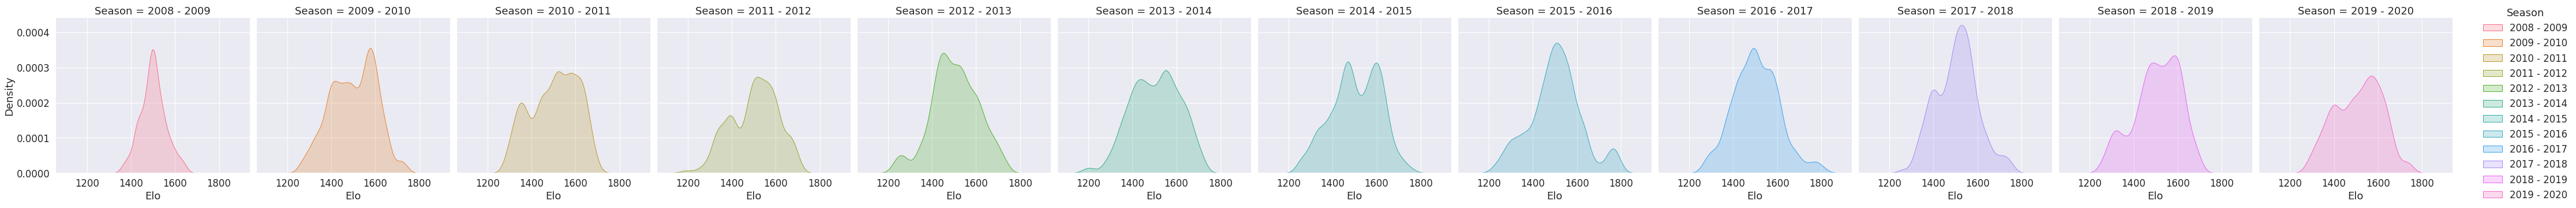

In [ ]:
%matplotlib inline

sns.displot(team_performances_df, x="Elo", hue="Season", col="Season", kind="kde", fill=True, height=5)

## 4.3 Examining ELO further per team

Next, we will look at the joint distribution of ELO and wins on a per-team basis, to determine if there's any significant correlation between the two.

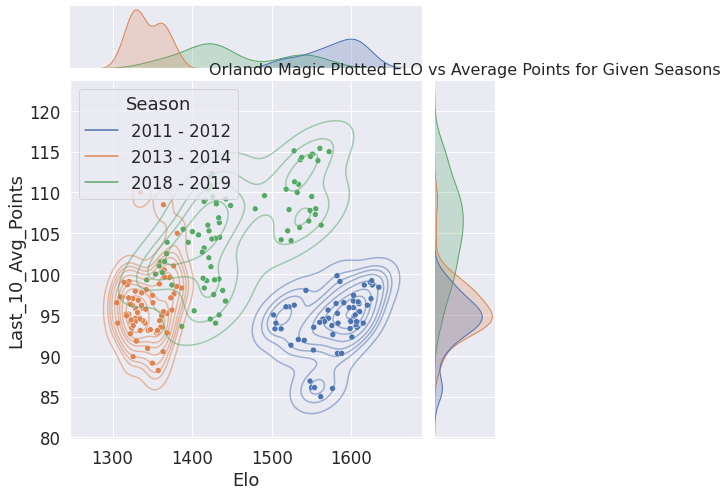

In [ ]:
random_team = random.choice(teams)
data = team_performances_df[team_performances_df['Team'] == random_team]
random_seasons = np.random.choice(list(set(team_performances_df['Season'].values)), size=3, replace=False)
data = data[data['Season'].isin(random_seasons)]


g = sns.jointplot(data = data, x="Elo", y="Last_10_Avg_Points", hue="Season", height=7)
plt.title("{} Plotted ELO vs Average Points for Given Seasons".format(random_team), y=1.3, fontsize = 16)
g.plot_joint(sns.kdeplot, alpha=0.5)


We can actually see from this that there is some correlation between the average number of points a team scores versus its ELO – the higher the average points scored across a window of games the higher the ELO seems to climb. However, we can also see that the ELO can exhibit a high variance across similar scoring figures, so we will examine ELO when compared with opponent data and with aggregate player data as well.

Furthermore, if we examine how the average points scored compares to season averages across the league, we can also safely state that high scoring improves ELO if high scoring is relative to the rest of the league

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

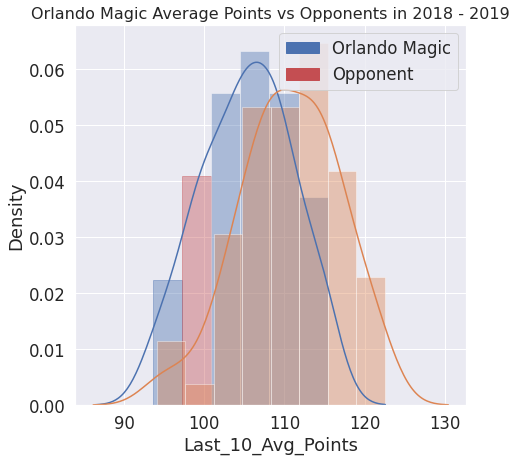

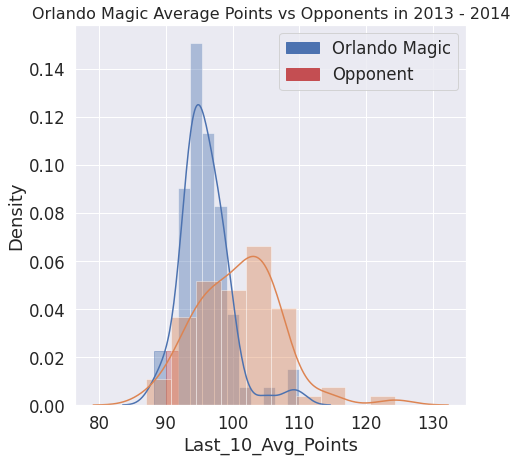

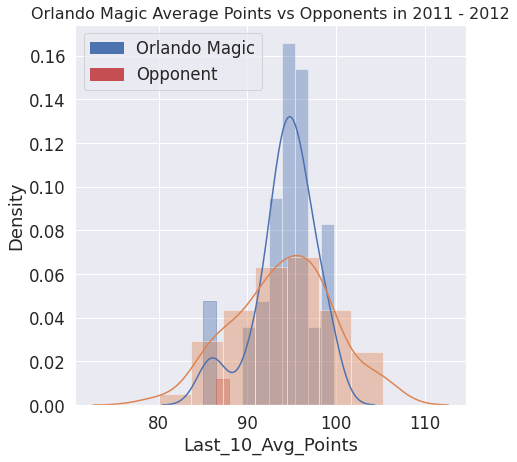

In [ ]:
import matplotlib.patches as mpatches

opponent_avg_points = []
for i, row in data.iterrows():
  game_id = row['Game_ID']
  opp_row = team_performances_df[team_performances_df['Game_ID'] == game_id]
  #print(opp_row.head(2))
  true_row = opp_row[opp_row['Team'] != random_team]
  #print(true_row['Last_10_Avg_Points'].values)
  opponent_avg_points.append(true_row["Last_10_Avg_Points"].values[0])
data['Opp_10_Avg_Points'] = opponent_avg_points

for season in random_seasons:
  fig, ax = plt.subplots(figsize=(7,7))
  new_data = data[data['Season'] == season]
  for a in [new_data['Last_10_Avg_Points'], new_data['Opp_10_Avg_Points']]:
    sns.distplot(a, ax=ax, kde=True)

  colors = ['b', 'r']
  labels = {'r':'Opponent', 'b':random_team }
  handles = []
  for col, patch in zip(colors, ax.axes.patches):
    patch.set_color(col)
    handles.append(mpatches.Patch(color=col, label=labels[col]))

  ax.legend(handles=handles)
  plt.title("{} Average Points vs Opponents in {}".format(random_team, season), fontsize = 16)
  plt.xlabel("Last_10_Avg_Points")

This confirms our suspiciouns, as we can see that when the groupings of average points is greater than those of its oponents, the ELO is higher for those seasons. When the groupings approach an even or lesser value, those seasons' ELO ratings for the given team are lower

## 4.4 ELO mapped with PER

Here, we will examine if there is a relationship between the ELO of a team and the aggregate PER of that team's players across multiple seasons.

PER is an advanced statistic that is widely used around the NBA. The PER is computed using a detailed, complex formula that, in essence, adds for positive stats such as rebounds, assists, and steals, and subtracts for negative stats such as shots missed or turnovers. We computed a PER using linear weights as follows:

PER = (FGM x 85.910 + Steals x 53.897 + 3PTM x 51.757 + FTM x 46.845 + Blocks x 39.190 + Offensive_Reb x 39.190 + Assists x 34.677 + Defensive_Reb x 14.707 - Foul x 17.174 - FT_Miss x 20.091 - FG_Miss x 39.190 - TO x 53.897) x (1 / Minutes)

We sourced this computation from this Bleacher Report article: https://bleacherreport.com/articles/113144-cracking-the-code-how-to-calculate-hollingers-per-without-all-the-mess


In [ ]:
player_stats['PER_stub'] = player_stats['FGM'] * 85.910 + player_stats['Stl'] * 53.897 + player_stats['3FGM'] * 51.757 + player_stats['FTM'] * 46.845 \
                           + player_stats['Blk'] * 39.190 + player_stats['OffReb'] * 39.190+ player_stats['Ast'] * 34.677+ player_stats['DefReb'] * 14.707 \
                           - player_stats['PFCom'] * 17.17 - player_stats['FTm'] * 20.091 - player_stats['FGm'] * 39.190 - player_stats['T/O'] * 53.897 


# raw PER intermediate value
player_stats['PER_stub'] = player_stats['FGM']*85.910+player_stats['Stl']*53.897+player_stats['3FGM']*51.757+player_stats['FTM']*46.845+player_stats['Blk']\
                          *39.190+player_stats['OffReb']*39.19+player_stats['Ast']*34.677+player_stats['DefReb']*14.707-player_stats['PFCom']*17.174-player_stats['FTm']\
                          *20.091-player_stats['FGm']*39.190-player_stats['T/O']*53.897


# calculate PER per player, per game 
player_stats['PER'] = player_stats['PER_stub'] * (1 / player_stats['Min'])

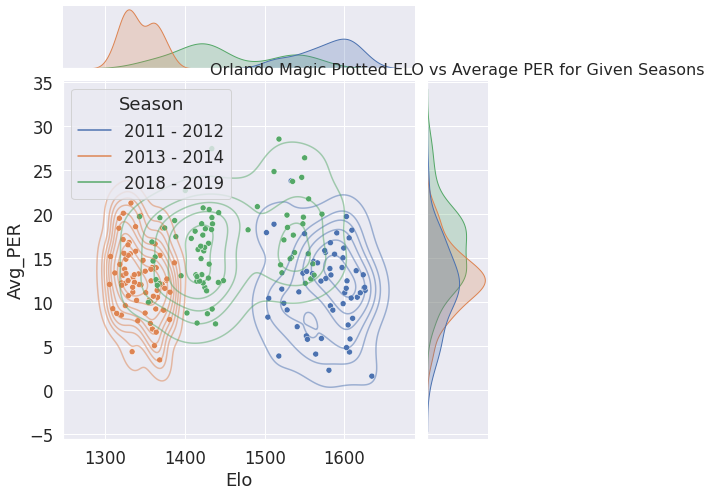

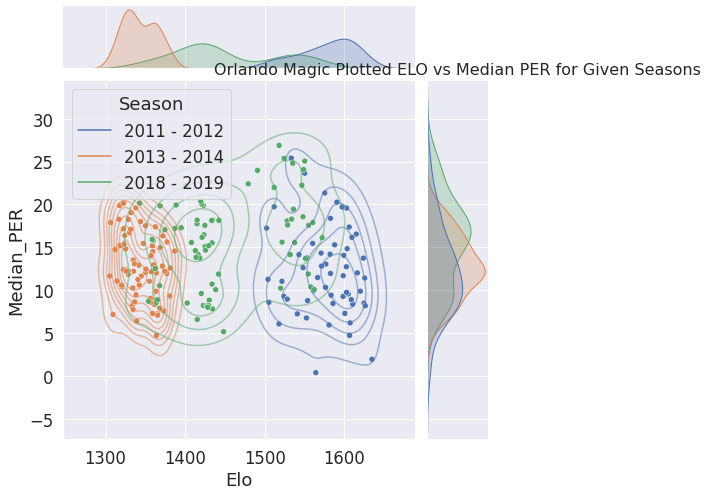

In [ ]:
team_per = []
team_per_median = []
for i, row in data.iterrows():
  game_id = row['Game_ID']
  opp_rows = player_stats[player_stats['GameID'] == game_id]
  #print(opp_row.head(2))
  true_rows = opp_rows[opp_rows['PlayerTeam'] == random_team]
  #print(true_row['Last_10_Avg_Points'].values)
  team_per.append(true_rows["PER"].values.mean())
  team_per_median.append(np.median(true_rows["PER"].values))
data['Avg_PER'] = team_per
data["Median_PER"] = team_per_median

g = sns.jointplot(data = data, x="Elo", y="Avg_PER", hue="Season", height=7)
plt.title("{} Plotted ELO vs Average PER for Given Seasons".format(random_team), y=1.3, fontsize = 16)
g.plot_joint(sns.kdeplot, alpha=0.5)

g = sns.jointplot(data = data, x="Elo", y="Median_PER", hue="Season", height=7)
plt.title("{} Plotted ELO vs Median PER for Given Seasons".format(random_team), y=1.3, fontsize = 16)
g.plot_joint(sns.kdeplot, alpha=0.5)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

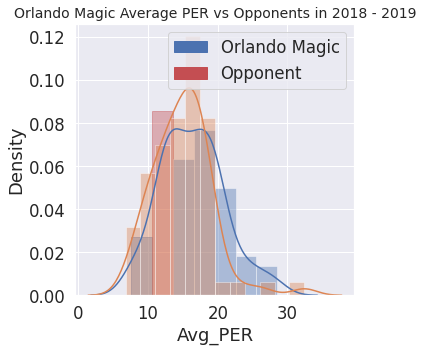

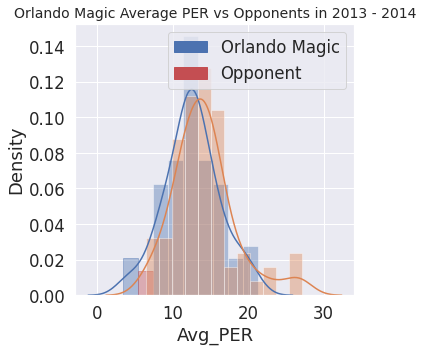

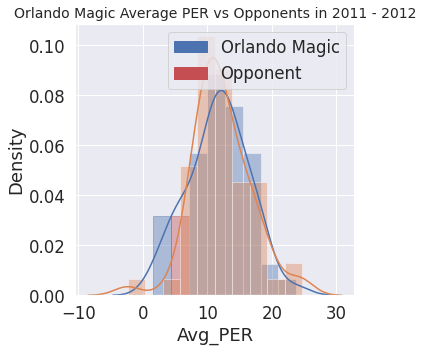

In [ ]:
team_per = []
team_per_median = []
for i, row in data.iterrows():
  game_id = row['Game_ID']
  opp_rows = player_stats[player_stats['GameID'] == game_id]
  #print(opp_row.head(2))
  true_rows = opp_rows[opp_rows['PlayerTeam'] != random_team]
  #print(true_row['Last_10_Avg_Points'].values)
  team_per.append(true_rows["PER"].values.mean())
  team_per_median.append(np.median(true_rows["PER"].values))
data['Opp_Avg_PER'] = team_per
data["Opp_Median_PER"] = team_per_median


for season in random_seasons:
  fig, ax = plt.subplots(figsize=(5,5))
  new_data = data[data['Season'] == season]
  for a in [new_data['Avg_PER'], new_data['Opp_Avg_PER']]:
    sns.distplot(a, ax=ax, kde=True)

  colors = ['b', 'r']
  labels = {'r':'Opponent', 'b':random_team }
  handles = []
  for col, patch in zip(colors, ax.axes.patches):
    patch.set_color(col)
    handles.append(mpatches.Patch(color=col, label=labels[col]))

  ax.legend(handles=handles)
  plt.title("{} Average PER vs Opponents in {}".format(random_team, season), fontsize = 14)
  plt.xlabel("Avg_PER")

It looks like the average PER as compared to opponents doesn't show a clear correlation between PER and the strength of a team: Average Points seems to translate better which makes some sense, a player's efficiency isn't necessarily tied to scoring the most points – which is the determinant of winning a game and therefore ELO.

Noting that the average can be subject to outliers on either side of the spectrum (high-efficiency players or low-efficiency players), we will take the Median PER as compared to opponents and see if that shows a greater correlation to the ELO of a team across the given season.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

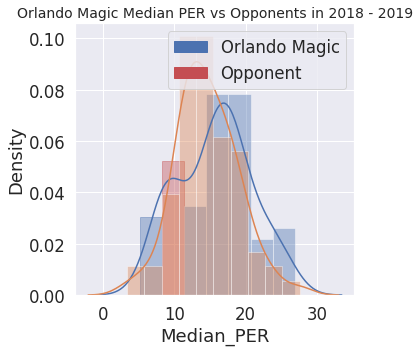

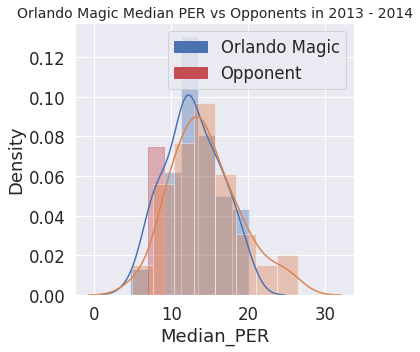

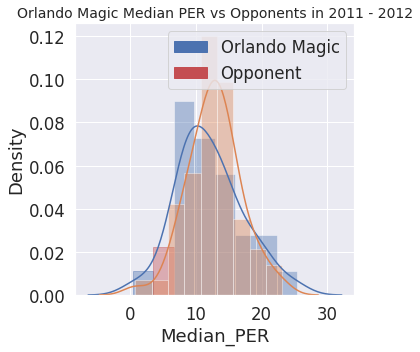

In [ ]:

for season in random_seasons:
  fig, ax = plt.subplots(figsize=(5,5))
  new_data = data[data['Season'] == season]
  for a in [new_data['Median_PER'], new_data['Opp_Median_PER']]:
    sns.distplot(a, ax=ax, kde=True)

  colors = ['b', 'r']
  labels = {'r':'Opponent', 'b':random_team }
  handles = []
  for col, patch in zip(colors, ax.axes.patches):
    patch.set_color(col)
    handles.append(mpatches.Patch(color=col, label=labels[col]))

  ax.legend(handles=handles)
  plt.title("{} Median PER vs Opponents in {}".format(random_team, season), fontsize = 14)
  plt.xlabel("Median_PER")

When we refer to the Median PER of a given team versus its opponents to see if there's a correlation between that and the strength of that team (ELO), the Median PER comparison looks to have a greater determination than the Average PER. 

This is likely the case as NBA teams can have wildly skewed PER data based on players with very negligible efficiency or high efficiency over a short span of playing time. Taking the median counts players who play solid minutes and are likely to be the main contributors on a team.

# Section 5: Predicting the Outcome of Games Based on Team Statistic and Elo Ratings
In this section we will attempt to predict the winner of a game based on how each team has perfomed recently and the Elo ratings of each team. We have already gathered this data in the feature engineering section. We will train a logistic regression model and a random forest classifier to see which performs better. Essentially, we are looking to predict 1 if the away team wins and 0 otherwise. 

## 5.1 Read in the data

In [ ]:
final_team_stats = pd.read_csv('/content/drive/MyDrive/CIS545 Final Project/Final_Team_Stats.csv', index_col = 0)

## 5.3 Break data into features and columns

In [ ]:
#drop columns that are not numeric

cols = [0,1,2,3,4,7,8, 18, 37]
final_team_stats.drop(final_team_stats.columns[cols],axis=1, inplace=True)

In [ ]:
features = final_team_stats.drop(columns = 'Label')
label = final_team_stats['Label']

Let's take a look at our final features

In [ ]:
features

## 5.4 Split into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split
# Your code goes here

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.2)

Now, we will explore two potential models that can help us predict the outcome of a game, which is the original goal of our project. 
 
 
We will use a Logistic Regression Model and a Random Forest Model, and we will spend a significant amount of time adjusting the parameters of these models. 

## 5.5 Logistic Regression Model

We'll start with a simple, non-parameterized Logistic Regression Model. Let's examine the parameters currently in use. 

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics

# create a simple, non-parameterized Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))

from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

We can experiment with different parameters to see if we can improve the model's accuracy. It turns out using max_iter=131 and verbose=2 slightly improves the testing accuracy. Nonetheless, it's hard to think we'll be able to have much luck guessing with these parameters.

In [ ]:
# create complex Logistic Regression with max_iter=131 
log_model = LogisticRegression(max_iter=131, verbose=2, random_state=42)
log_model.fit(x_train, y_train)
y_pred_log = log_model.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_log))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6694881096332124


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Hyperparameter tuning in general relies more on experimental results than theory, and thus the best method to determine the optimal settings is to try out lots of different combinations and evaluate the performance of each model. However, evaluating each model only on the training set can lead to one of the most fundamental problems in machine learning: overfitting. 

We look to solve this problem using cross-validation. Since we only have a vague idea of the parameters we might want to use, the best approach is to narrow our search is to evaluate a wide range of values for each hyperparameter.

Let's try and optimize parameters for the Logistic Regression using RandomizedSearchCV. This should give us a better general sense of what parameters to use. To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Penalty type 
penalty = ['l1', 'l2', 'elasticnet', 'none']
# Solver type 
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# Maximum number of iterations 
max_iter = [int(x) for x in np.linspace(start = 0, stop = 1000, num = 11)]
# Multi class 
multi_class = ['auto', 'ovr', 'multinomial']
# Verbosity 
verbose = [0, 1, 2]
# l1 ratio 
l1_ratio = [0, 0.25, 0.5, 0.75, 1]
# C
C = [0.5, 1.0, 1.5]


# Create the random grid
random_grid = {
    'penalty': penalty, 'solver': solver, 'max_iter':max_iter, 
    'multi_class':multi_class, 'verbose':verbose, 'l1_ratio':l1_ratio, 
    'C':C
}
pprint(random_grid)

{'C': [0.5, 1.0, 1.5],
 'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
 'max_iter': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'multi_class': ['auto', 'ovr', 'multinomial'],
 'penalty': ['l1', 'l2', 'elasticnet', 'none'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
 'verbose': [0, 1, 2]}


On each iteration, the algorithm will choose a difference combination of the features. Altogether, this amounts to 2 * 4 * 5 * 11 * 3 * 3 * 5 * 3 = 59,400 settings. However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

Now, we instantiate the random search and fit it like any Scikit-Learn model:

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
log_reg = LogisticRegression(random_state=42)
# Random search of parameters, using 2-fold cross validation, 
# search across 100 different combinations, and use all available cores
log_random = RandomizedSearchCV(estimator = log_reg, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, n_jobs = -1)
# Fit the random search model
log_random.fit(x_train, y_train)
y_pred_log_random = log_random.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_log_random))

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
0.6662636033857315


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


We can view the optimal parameters from our RandomSearchCV with the following command: 

In [ ]:
log_random.best_params_

{'C': 1.5,
 'l1_ratio': 0,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'penalty': 'none',
 'solver': 'saga',
 'verbose': 1}

To determine if random search yielded a better model, we compare the base model with the best random search model.

In [ ]:
basic_model = LogisticRegression(random_state=42)
basic_model.fit(x_train, y_train)
y_pred_basic = basic_model.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_basic))

best_log_random = log_random.best_estimator_
best_log_random.fit(x_train, y_train)
y_pred_best_log_random = best_log_random.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_best_log_random))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend Sequentia

0.6698911729141476
max_iter reached after 1 seconds
0.6662636033857315


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


We saw a marginal decrease in the test accuracy using a RandomizedSearchCV. Random search allowed us to narrow down the range for each hyperparameter though. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of grid search 
# Penalty type 
penalty = ['l1', 'l2', 'elasticnet', 'none']
# Solver type 
solver = ['lbfgs', 'liblinear']
# Maximum number of iterations 
max_iter = [int(x) for x in np.linspace(start = 80, stop = 120, num = 5)]
# Multi class 
multi_class = ['auto', 'ovr']
# Verbosity 
verbose = [0, 1, 2]
# l1 ratio 
l1_ratio = [0, 0.8, 0.9, 1]
# C
C = [0.5, 0.75, 1.0, 1.25, 1.5]

# Create the param grid
param_grid = {'penalty': penalty, 'solver': solver, 'max_iter':max_iter, 
    'multi_class':multi_class, 'verbose':verbose, 'l1_ratio':l1_ratio, 
    'C':C
}
pprint(param_grid)

# Instantiate the grid search model with 2-fold cross-validation
log_grid_search = GridSearchCV(estimator = LogisticRegression(random_state=42), param_grid = param_grid, cv = 2, n_jobs = -1)

{'C': [0.5, 0.75, 1.0, 1.25, 1.5],
 'l1_ratio': [0, 0.8, 0.9, 1],
 'max_iter': [80, 90, 100, 110, 120],
 'multi_class': ['auto', 'ovr'],
 'penalty': ['l1', 'l2', 'elasticnet', 'none'],
 'solver': ['lbfgs', 'liblinear'],
 'verbose': [0, 1, 2]}


This will try out 2 * 5 * 4 * 5 * 2 * 4 * 2 * 3 = 9,600 different combinations of parameters. We will then fit the GridSearchCV below.

In [ ]:
# Fit the grid search to the data
log_grid_search.fit(x_train, y_train)
best_log_grid = log_grid_search.best_estimator_
best_log_grid.fit(x_train, y_train)
y_pred_best_log = best_log_grid.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_best_log))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


0.6694881096332124


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


It looks like we were able to slightly increase our testing accuracy using GridSearchCV, but it wasn't a significant increase. Nonetheless, 67% testing accuracy with sports data is significant.

Let's view the optimal parameters from our GridSearchCV:

In [ ]:
log_grid_search.best_params_

{'C': 1.0,
 'l1_ratio': 0,
 'max_iter': 90,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'verbose': 0}

## 5.6 Random Forest Classifier Model 
We will also try another model: a Random Forest Classifier. We will optimize parameters using a similar process as above. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_rf))

from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

0.6694881096332124
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


There are a lot of parameters to adjust, but let's focus on: n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap. We will use a RandomizedSearchCV to tune the hyperparameters listed before examining them further. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 2000, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 100, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [0, 20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Now, we instantiate the random search and fit it like any Scikit-Learn model:

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state=42)
# Random search of parameters, using 2-fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, n_jobs = -1)
# Fit the random search model
rfc_random.fit(x_train, y_train)
y_pred_rfr_random = rfc_random.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_rfr_random))

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 60.1min finished


0.6715034260378879


Let's take a look at what optimal parameters our RandomizedSearchCV yielded: 

In [ ]:
rfc_random.best_params_

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 200}

To determine if random search yielded a better model, we compare the base model with the best random search model.

In [ ]:
base_model = RandomForestClassifier(random_state=42)
base_model.fit(x_train, y_train)
y_pred_base = base_model.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_base))

best_random = rfc_random.best_estimator_
best_random.fit(x_train, y_train)
y_pred_random = best_random.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_random))

0.6694881096332124
0.6670697299476017


Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of grid search 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1600, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 5, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(param_grid)

# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model with 2-fold cross-validation
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2)

This will try out 2 * 1 * 6 * 2 * 3 * 3 * 5 = 1080 combinations of settings. We can fit the model, display the best hyperparameters, and evaluate performance:

In [ ]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
best_grid = grid_search.best_estimator_
best_grid.fit(x_train, y_train)
y_pred_best = best_grid.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_best))

Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 76.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 135.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 152.2min finished


0.6711003627569528


It appears even with optimization, the Random Forest Classifier Model still performs worse than the Logistic Regression Model. There is a chance another model could produce a higher testing accuracy than the Logistic Regression, and we would hope to explore more models if we had more time. 

# Section 6: Predicting the Outcome of Games Based on Individual Player Scoring Statistics
We will now take a different approach to predicting the outcome of a game to see if we can achieve any better perfomance. Using the larger dataset of individual player statistics that we've collected we will train a model to predict how many points a player will score in a given game. We will predict this based on a players average season stats up until the game we are trying to predict as well as their average perfomance over the past 10 games. We already created this data in the feature engineering section above. We will also make use of Elo ratings in our prediction as well, as presumbly the higher rating of the opposing team the less points a player will score. Once we have this model we can predict how many points a team will score in a game by summing up the predicted number of points of each individual player will score. With this information we will be able to predict which team will score more points and thus win the game. 

## 6.1 Reading in the data 


In [ ]:
final_player_stats = pd.read_csv('/content/drive/MyDrive/CIS545 Final Project/Final_Player_Stats.csv', index_col = 0)
final_team_stats = pd.read_csv('/content/drive/MyDrive/CIS545 Final Project/Final_Team_Stats.csv', index_col = 0)
final_team_stats.sort_values(by = 'Date', inplace = True)

player_stats = pd.read_csv('/content/drive/MyDrive/CIS545 Final Project/NBA_Combined_Player_Stats.csv', index_col = 0)
team_stats = pd.read_csv('/content/drive/MyDrive/CIS545 Final Project/NBA_Combined_Team_Stats.csv', index_col = 0)

## 6.2 Add Elo ratings column 
We almost have all the data we need to predict how many points a player will score in our **final_player_stats** data. However, one more feature we will add is the Elo ratings of the opposing team. This will be saved as the column "Opp_Team_Elo_Rating"

In [ ]:
h_team_elos = final_team_stats[['Game_ID', 'H_Team', 'H_Team_Elo_Before']].rename(columns = {'H_Team' : 'Team', 'H_Team_Elo_Before': 'Elo_Rating'})
a_team_elos = final_team_stats[['Game_ID', 'A_Team', 'A_Team_Elo_Before']].rename(columns = {'A_Team' : 'Team', 'A_Team_Elo_Before': 'Elo_Rating'})

final_player_stats = final_player_stats.merge(pd.concat([h_team_elos, a_team_elos]), left_on=['GameID', 'OpposingTeam'], right_on=['Game_ID', 'Team']) \
                                                                                                                  .drop(columns = ['Game_ID', 'Team'])

final_player_stats.rename(columns={'Elo_Rating': 'Opp_Team_Elo_Rating'}, inplace = True)      

final_player_stats

,PlayerName,PlayerTeam,OpposingTeam,Date,GameID,Season,Avg_Season_Min,Avg_Season_SST,Avg_Season_Pts,Avg_Season_PPP,Avg_Season_Ast,Avg_Season_T/O,Avg_Season_Ast/TO,Avg_Season_Stl,Avg_Season_StlPos,Avg_Season_Blk,Avg_Season_BlkFGA,Avg_Season_TtlReb,Avg_Season_OffReb,Avg_Season_DefReb,Avg_Season_FGA,Avg_Season_FGM,Avg_Season_FGm,Avg_Season_2FGA,Avg_Season_2FGM,Avg_Season_2FGm,Avg_Season_3FGA,Avg_Season_3FGM,Avg_Season_3FGm,Avg_Season_FTA,Avg_Season_FTM,Avg_Season_FTm,Avg_Season_PFTkn,Avg_Season_PFCom,Last_10_Avg_Min,Last_10_Avg_SST,Last_10_Avg_Pts,Last_10_Avg_PPP,Last_10_Avg_Ast,Last_10_Avg_T/O,Last_10_Avg_Ast/TO,Last_10_Avg_Stl,Last_10_Avg_StlPos,Last_10_Avg_Blk,Last_10_Avg_BlkFGA,Last_10_Avg_TtlReb,Last_10_Avg_OffReb,Last_10_Avg_DefReb,Last_10_Avg_FGA,Last_10_Avg_FGM,Last_10_Avg_FGm,Last_10_Avg_2FGA,Last_10_Avg_2FGM,Last_10_Avg_2FGm,Last_10_Avg_3FGA,Last_10_Avg_3FGM,Last_10_Avg_3FGm,Last_10_Avg_FTA,Last_10_Avg_FTM,Last_10_Avg_FTm,Last_10_Avg_PFTkn,Last_10_Avg_PFCom,Opp_Team_Elo_Rating
0,Brandon Roy,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,34.000000,2.090000,26.000000,1.180000,7.000000,1.000000,7.000000,3.000000,0.000000,0.000000,0.000000,5.000000,1.000000,4.000000,18.000000,10.000000,8.000000,15.000000,9.000000,6.000000,3.000000,1.000000,2.000000,7.000000,5.000000,2.000000,5.000000,0.000000,34.000000,2.090,26.0,1.180,7.0,1.0,7.000,3.0,0.0,0.0,0.0,5.0,1.0,4.0,18.0,10.0,8.0,15.0,9.0,6.0,3.0,1.0,2.0,7.0,5.0,2.0,5.0,0.0,1485.345335
1,Channing Frye,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,13.000000,1.380000,10.000000,1.110000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000,9.000000,5.000000,4.000000,9.000000,5.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,1.380,10.0,1.110,0.0,0.0,0.000,1.0,0.0,0.0,0.0,3.0,1.0,2.0,9.0,5.0,4.0,9.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1485.345335
2,Travis Outlaw,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,31.000000,1.330000,11.000000,0.850000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,4.000000,0.000000,4.000000,9.000000,2.000000,7.000000,8.000000,1.000000,7.000000,1.000000,1.000000,0.000000,6.000000,6.000000,0.000000,4.000000,0.000000,31.000000,1.330,11.0,0.850,1.0,0.0,0.000,3.0,0.0,0.0,0.0,4.0,0.0,4.0,9.0,2.0,7.0,8.0,1.0,7.0,1.0,1.0,0.0,6.0,6.0,0.0,4.0,0.0,1485.345335
3,Lamarcus Aldridge,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,42.000000,1.010000,23.000000,1.100000,3.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,5.000000,2.000000,3.000000,22.000000,10.000000,12.000000,20.000000,9.000000,11.000000,2.000000,1.000000,1.000000,4.000000,2.000000,2.000000,2.000000,0.000000,42.000000,1.010,23.0,1.100,3.0,1.0,3.000,1.0,0.0,0.0,0.0,5.0,2.0,3.0,22.0,10.0,12.0,20.0,9.0,11.0,2.0,1.0,1.0,4.0,2.0,2.0,2.0,0.0,1485.345335
4,Sergio Rodriguez,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,9.000000,0.990000,3.000000,0.750000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,3.000000,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.990,3.0,0.750,2.0,1.0,2.000,1.0,0.0,0.0,0.0,2.0,0.0,2.0,3.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1485.345335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255508,Jamal Murray,Denver Nuggets,Toronto Raptors,2020-08-14,732814,2019 - 2020,32.620175,1.300175,18.701754,0.959298,4.859649,2.192982,2.301228,1.140351,1.543860,0.298246,0.456140,4.052632,0.771930,3.280702,15.350877,7.017544,8.333333,9.824561,5.157895,4.666667,5.526316,1.859649,3.666667,3.175439,2.807018,0.368421,3.017544,1.736842,33.216667,1.188,17.5,0.998,5.1,1

## 6.3 Add a label column 
The label in this case will be how many points the player scored in a given game. We get this data from the points column in the player stats that we originally scraped

In [ ]:
final_player_stats = final_player_stats.merge(player_stats[['GameID', 'Pts', 'PlayerName']], left_on=['GameID', 'PlayerName'], right_on=['GameID', 'PlayerName'])
final_player_stats

,PlayerName,PlayerTeam,OpposingTeam,Date,GameID,Season,Avg_Season_Min,Avg_Season_SST,Avg_Season_Pts,Avg_Season_PPP,Avg_Season_Ast,Avg_Season_T/O,Avg_Season_Ast/TO,Avg_Season_Stl,Avg_Season_StlPos,Avg_Season_Blk,Avg_Season_BlkFGA,Avg_Season_TtlReb,Avg_Season_OffReb,Avg_Season_DefReb,Avg_Season_FGA,Avg_Season_FGM,Avg_Season_FGm,Avg_Season_2FGA,Avg_Season_2FGM,Avg_Season_2FGm,Avg_Season_3FGA,Avg_Season_3FGM,Avg_Season_3FGm,Avg_Season_FTA,Avg_Season_FTM,Avg_Season_FTm,Avg_Season_PFTkn,Avg_Season_PFCom,Last_10_Avg_Min,Last_10_Avg_SST,Last_10_Avg_Pts,Last_10_Avg_PPP,Last_10_Avg_Ast,Last_10_Avg_T/O,Last_10_Avg_Ast/TO,Last_10_Avg_Stl,Last_10_Avg_StlPos,Last_10_Avg_Blk,Last_10_Avg_BlkFGA,Last_10_Avg_TtlReb,Last_10_Avg_OffReb,Last_10_Avg_DefReb,Last_10_Avg_FGA,Last_10_Avg_FGM,Last_10_Avg_FGm,Last_10_Avg_2FGA,Last_10_Avg_2FGM,Last_10_Avg_2FGm,Last_10_Avg_3FGA,Last_10_Avg_3FGM,Last_10_Avg_3FGm,Last_10_Avg_FTA,Last_10_Avg_FTM,Last_10_Avg_FTm,Last_10_Avg_PFTkn,Last_10_Avg_PFCom,Opp_Team_Elo_Rating,Pts
0,Brandon Roy,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,34.000000,2.090000,26.000000,1.180000,7.000000,1.000000,7.000000,3.000000,0.000000,0.000000,0.000000,5.000000,1.000000,4.000000,18.000000,10.000000,8.000000,15.000000,9.000000,6.000000,3.000000,1.000000,2.000000,7.000000,5.000000,2.000000,5.000000,0.000000,34.000000,2.090,26.0,1.180,7.0,1.0,7.000,3.0,0.0,0.0,0.0,5.0,1.0,4.0,18.0,10.0,8.0,15.0,9.0,6.0,3.0,1.0,2.0,7.0,5.0,2.0,5.0,0.0,1485.345335,20
1,Channing Frye,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,13.000000,1.380000,10.000000,1.110000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000,9.000000,5.000000,4.000000,9.000000,5.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,1.380,10.0,1.110,0.0,0.0,0.000,1.0,0.0,0.0,0.0,3.0,1.0,2.0,9.0,5.0,4.0,9.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1485.345335,6
2,Travis Outlaw,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,31.000000,1.330000,11.000000,0.850000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,4.000000,0.000000,4.000000,9.000000,2.000000,7.000000,8.000000,1.000000,7.000000,1.000000,1.000000,0.000000,6.000000,6.000000,0.000000,4.000000,0.000000,31.000000,1.330,11.0,0.850,1.0,0.0,0.000,3.0,0.0,0.0,0.0,4.0,0.0,4.0,9.0,2.0,7.0,8.0,1.0,7.0,1.0,1.0,0.0,6.0,6.0,0.0,4.0,0.0,1485.345335,11
3,Lamarcus Aldridge,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,42.000000,1.010000,23.000000,1.100000,3.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,5.000000,2.000000,3.000000,22.000000,10.000000,12.000000,20.000000,9.000000,11.000000,2.000000,1.000000,1.000000,4.000000,2.000000,2.000000,2.000000,0.000000,42.000000,1.010,23.0,1.100,3.0,1.0,3.000,1.0,0.0,0.0,0.0,5.0,2.0,3.0,22.0,10.0,12.0,20.0,9.0,11.0,2.0,1.0,1.0,4.0,2.0,2.0,2.0,0.0,1485.345335,16
4,Sergio Rodriguez,Portland Trail Blazers,Phoenix Suns,2008-11-01,10607,2008 - 2009,9.000000,0.990000,3.000000,0.750000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,3.000000,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.990,3.0,0.750,2.0,1.0,2.000,1.0,0.0,0.0,0.0,2.0,0.0,2.0,3.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1485.345335,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255510,Jamal Murray,Denver Nuggets,Toronto Raptors,2020-08-14,732814,2019 - 2020,32.620175,1.300175,18.701754,0.959298,4.859649,2.192982,2.301228,1.140351,1.543860,0.298246,0.456140,4.052632,0.771930,3.280702,15.350877,7.017544,8.333333,9.824561,5.157895,4.666667,5.526316,1.859649,3.666667,3.175439,2.807018,0.368421,3.017544,1.736842,33.216667,1

## 6.4 Remove any games where we don't have enough player statistics
For some games in this dataset, we have the statisitcs for one teams players, but not for the other team. This is becuase if a team hasn't played a game yet their will be no prior statistics for that teams players. Thus, we will remove all these games from the dataset.

In [ ]:
game_id_value_counts = final_player_stats['GameID'].value_counts()
valid_game_ids = [x for x in final_player_stats['GameID'] if game_id_value_counts[x] > 16]

final_player_stats = final_player_stats[final_player_stats['GameID'].isin(valid_game_ids)]

## 6.5 Splitting into features and label

In [ ]:
cols = [4,6,8,9,20,21,22,23,24,25,26,27,28,29,30,31,34,36,37,48,49,50,51,52,53,54,55,56,57,58,59, 62]
features = final_player_stats.iloc[:, cols]
label = final_player_stats[['GameID','Pts']]

Lets take a look at our features. We have 32 in total. They contain the average season and recent scoring and shooting statistics of a player before a game as well as the opposing team Elo rating.



In [ ]:
features

,GameID,Avg_Season_Min,Avg_Season_Pts,Avg_Season_PPP,Avg_Season_FGA,Avg_Season_FGM,Avg_Season_FGm,Avg_Season_2FGA,Avg_Season_2FGM,Avg_Season_2FGm,Avg_Season_3FGA,Avg_Season_3FGM,Avg_Season_3FGm,Avg_Season_FTA,Avg_Season_FTM,Avg_Season_FTm,Last_10_Avg_Min,Last_10_Avg_Pts,Last_10_Avg_PPP,Last_10_Avg_FGA,Last_10_Avg_FGM,Last_10_Avg_FGm,Last_10_Avg_2FGA,Last_10_Avg_2FGM,Last_10_Avg_2FGm,Last_10_Avg_3FGA,Last_10_Avg_3FGM,Last_10_Avg_3FGm,Last_10_Avg_FTA,Last_10_Avg_FTM,Last_10_Avg_FTm,Opp_Team_Elo_Rating
0,10607,34.000000,26.000000,1.180000,18.000000,10.000000,8.000000,15.000000,9.000000,6.000000,3.000000,1.000000,2.000000,7.000000,5.000000,2.000000,34.000000,26.0,1.180,18.0,10.0,8.0,15.0,9.0,6.0,3.0,1.0,2.0,7.0,5.0,2.0,1485.345335
1,10607,13.000000,10.000000,1.110000,9.000000,5.000000,4.000000,9.000000,5.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,10.0,1.110,9.0,5.0,4.0,9.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1485.345335
2,10607,31.000000,11.000000,0.850000,9.000000,2.000000,7.000000,8.000000,1.000000,7.000000,1.000000,1.000000,0.000000,6.000000,6.000000,0.000000,31.000000,11.0,0.850,9.0,2.0,7.0,8.0,1.0,7.0,1.0,1.0,0.0,6.0,6.0,0.0,1485.345335
3,10607,42.000000,23.000000,1.100000,22.000000,10.000000,12.000000,20.000000,9.000000,11.000000,2.000000,1.000000,1.000000,4.000000,2.000000,2.000000,42.000000,23.0,1.100,22.0,10.0,12.0,20.0,9.0,11.0,2.0,1.0,1.0,4.0,2.0,2.0,1485.345335
4,10607,9.000000,3.000000,0.750000,3.000000,1.000000,2.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,9.000000,3.0,0.750,3.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,1485.345335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255510,732814,32.620175,18.701754,0.959298,15.350877,7.017544,8.333333,9.824561,5.157895,4.666667,5.526316,1.859649,3.666667,3.175439,2.807018,0.368421,33.216667,17.5,0.998,15.1,6.7,8.4,8.5,4.5,4.0,6.6,2.2,4.4,2.3,1.9,0.4,1688.425706
255511,732814,10.835926,4.088889,0.988000,3.755556,1.466667,2.288889,1.111111,0.511111,0.600000,2.644444,0.955556,1.688889,0.333333,0.200000,0.133333,8.398333,3.1,1.245,3.1,1.1,2.0,0.6,0.3,0.3,2.5,0.8,1.7,0.3,0.1,0.2,1688.425706
255512,732814,10.492157,3.764706,0.987353,2.558824,1.470588,1.088235,2.176471,1.382353,0.794118,0.382353,0.088235,0.294118,0.941176,0.735294,0.205882,5.236667,2.3,1.066,1.3,0.9,0.4,1.1,0.7,0.4,0.2,0.2,0.0,0.6,0.3,0.3,1688.425706
255513,732814,13.594643,5.285714,0.616071,5.285714,2.107143,3.178571,3.750000,1.678571,2.071429,1.535714,0.428571,1.107143,0.928571,0.642857,0.285714,14.986667,6.2,0.514,5.9,2.3,3.6,4.3,1.8,2.5,1.6,0.5,1.1,1.5,1.1,0.4,1688.425706


## 6.5 Splitting into train set and test set

Unfortunately we can't randomly split our data into train and test sets. We are looking to use individual player statistics to predict the final score of a team, thus we must keep all players playing in the same game together. To do this, we will split up our train and test sets by game so player playing in the same game stay together. About 80% of the games will be in the train set and 20% will be in the test set. 

In [ ]:
import random 
games = set(final_player_stats['GameID'].unique())

train_set_game_ids = random.sample(games, 9700)

x_train = features[features['GameID'].isin(train_set_game_ids)].drop(columns = 'GameID')
y_train = label[label['GameID'].isin(train_set_game_ids)].drop(columns = 'GameID')

x_test = features[features['GameID'].isin(train_set_game_ids) == False].drop(columns = 'GameID')
y_test = label[label['GameID'].isin(train_set_game_ids) == False].drop(columns = 'GameID')


## 6.6 Scale the data 
Here we will standardize the data using sklearns StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train) 
x_test = scaler.transform(x_test)

## 6.7 Linear Regression Model
We will now use linear regression to predict how many points a player will score in a given game.

In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import numpy as np

model = LinearRegression() 
model.fit(x_train, y_train) 
predictions = model.predict(x_test)

In [ ]:
print("Score:", model.score(x_test, y_test))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

Score: 0.5048039049156544
MSE: 30.872873834952454
RMSE: 5.556336368053365


We have a root mean squared error of about 5.56. This is the equivalenet of a player making our missing 2 or 3 baskets.

## 6.8 Predict team scores based on player scoring predictions
Now that we have our predictions for how many points each player in the test set will score. We will now use these predictions to predict how many points the entire team will score in a given game. This will be done by grouping by team and game and summing the number of points each player is predicted to score. We will save this to the dataframe called **predicted_team_points**

In [ ]:
#now we will match the predictions up with game and team they came from 

y_test['Predicted'] = predictions
predicted_vs_actual_pts_scored = y_test.rename(columns = {'Pts' : 'Actual'})
predicted_player_points = final_player_stats[['GameID', 'PlayerTeam']].merge(predicted_vs_actual_pts_scored, left_index = True, right_index = True)

predicted_team_points = predicted_player_points.groupby(['PlayerTeam', 'GameID']).sum().reset_index().drop(columns = 'Actual')
predicted_team_points.rename(columns = {'PlayerTeam':'Team', 'Predicted' : 'PredictedPts'}, inplace = True)
predicted_team_points

,Team,GameID,PredictedPts
0,Atlanta Hawks,11610,106.885563
1,Atlanta Hawks,18718,99.402227
2,Atlanta Hawks,18869,107.625132
3,Atlanta Hawks,18936,103.163885
4,Atlanta Hawks,18946,103.493267
...,...,...,...
5051,Washington Wizards,632484,97.431288
5052,Washington Wizards,632534,100.476565
5053,Washington Wizards,732748,76.837004
5054,Washington Wizards,732774,87.463994


## 6.9 Evaluate our accuracy
We have predictions for how many points each team in our test set will score. We will now see how many games we correctly predict with this information. 


Merge our predictions with the actual results of each game so we can see side by side results.

In [ ]:
predicted_winner_df = team_stats.iloc[:,[0,1,3,4,9,10]].merge(predicted_team_points, left_on = ['H_Team', 'Game_ID'], right_on = ['Team', 'GameID']).drop(columns = ['Team', 'GameID'])
predicted_winner_df.rename(columns = {'PredictedPts' : 'H_Predicted_Points'}, inplace = True)

predicted_winner_df = predicted_winner_df.merge(predicted_team_points, left_on = ['A_Team', 'Game_ID'], right_on = ['Team', 'GameID']).drop(columns = ['Team', 'GameID'])
predicted_winner_df.rename(columns = {'PredictedPts' : 'A_Predicted_Points'},inplace=True)

predicted_winner_df

,Date,Game_ID,H_Team,A_Team,H_Points,A_Points,H_Predicted_Points,A_Predicted_Points
0,2020-08-13,732808,Orlando Magic,New Orleans Pelicans,133,127,74.949977,51.278776
1,2020-08-13,732809,Phoenix Suns,Dallas Mavericks,128,102,118.640594,118.942869
2,2020-08-13,732806,Los Angeles Lakers,Sacramento Kings,122,136,77.359548,95.885482
3,2020-08-11,732798,Sacramento Kings,New Orleans Pelicans,112,106,91.292422,59.021020
4,2020-08-10,732792,Los Angeles Lakers,Denver Nuggets,124,121,108.838981,97.618855
...,...,...,...,...,...,...,...,...
2523,2008-11-12,10769,Oklahoma City Thunder,Orlando Magic,92,109,71.049107,107.124171
2524,2008-11-12,10768,New Orleans Pelicans,Los Angeles Lakers,86,93,99.965514,106.062355
2525,2008-11-09,10709,Los Angeles Lakers,Houston Rockets,111,82,112.694766,97.699734
2526,2008-11-03,10613,Memphis Grizzlies,Golden State Warriors,90,79,91.589580,107.550548


Create columns for the actual winner of the game and our predicted winner. These columns will be 1 if the home team wins and 0 otherwise. 

In [ ]:
predicted_winner_df['Actual'] = [1 if x > 0 else 0 for x in predicted_winner_df['H_Points'] - predicted_winner_df['A_Points']]
predicted_winner_df['Predicted'] = [1 if x > 0 else 0 for x in predicted_winner_df['H_Predicted_Points'] - predicted_winner_df['A_Predicted_Points']]

predicted_winner_df

,Date,Game_ID,H_Team,A_Team,H_Points,A_Points,H_Predicted_Points,A_Predicted_Points,Actual,Predicted
0,2020-08-13,732808,Orlando Magic,New Orleans Pelicans,133,127,74.949977,51.278776,1,1
1,2020-08-13,732809,Phoenix Suns,Dallas Mavericks,128,102,118.640594,118.942869,1,0
2,2020-08-13,732806,Los Angeles Lakers,Sacramento Kings,122,136,77.359548,95.885482,0,0
3,2020-08-11,732798,Sacramento Kings,New Orleans Pelicans,112,106,91.292422,59.021020,1,1
4,2020-08-10,732792,Los Angeles Lakers,Denver Nuggets,124,121,108.838981,97.618855,1,1
...,...,...,...,...,...,...,...,...,...,...
2523,2008-11-12,10769,Oklahoma City Thunder,Orlando Magic,92,109,71.049107,107.124171,0,0
2524,2008-11-12,10768,New Orleans Pelicans,Los Angeles Lakers,86,93,99.965514,106.062355,0,0
2525,2008-11-09,10709,Los Angeles Lakers,Houston Rockets,111,82,112.694766,97.699734,1,1
2526,2008-11-03,10613,Memphis Grizzlies,Golden State Warriors,90,79,91.589580,107.550548,1,0


Calculate the percentage of correctly predicted games

In [ ]:
accuracy = sum(predicted_winner_df['Actual'] == predicted_winner_df['Predicted']) / len(predicted_winner_df)

print('Number of games predicted:', len(predicted_winner_df))
print('Number of correctly predicted game:', sum(predicted_winner_df['Actual'] == predicted_winner_df['Predicted']))
print('Accuracy:', accuracy)

Number of games predicted: 2528
Number of correctly predicted game: 1483
Accuracy: 0.586629746835443


This model clearly performed much worse than our earlier model with an accuracy of 58.6%. Player performance is much more variable than overall team performance so trying to predict team performance through individual players likely isn't the best route to go. 

# Conclusions and Future Considerations

As avid NBA fans, we felt that creating a model to predict the outcome of NBA games would be an interesting project. We employed various data science tools we learned throughout the course in our analysis, including data scraping, data cleaning, feature engineering, and machine learning. We trained and tested various classifier models to see how good we could fit the testing data to the model. 


The logistic regression model, with parameters optimized through GridSearchCV, gives us the highest testing accuracy. It is slightly higher than the Random Forest Model, and it is much higher than the linear regression model based on individual player statistics. Optimizing parameters using GridSearchCV and RandomizedSearchCV was time consuming and computationally costly, and it resulted in only marginal changes in testing accuracy. If we had more time, we’d likely spend less time optimizing parameters and more time selecting a model. 


The best NBA game prediction models only accurately predict the winner about 70% of the time, so our logistic regression model is close to ideal. Logistic Regression outputs predictions about test data points on a binary scale, zero or one. If the value of something is 0.5 or above, it is classified as belonging to class 1, while below 0.5 if is classified as belonging to 0. If we had more time, we would explore other models. Some candidates include an SGD Classifier, linear discriminant analysis, or a naïve Bayes classifier.